# Inprocessing Bias Mitigation Techniques

## Load Data

In [22]:
import sys
import os
# Add the root directory of the project to PYTHONPATH
sys.path.append(os.path.abspath(os.path.join('../../master-thesis-dizio-ay2324')))

In [23]:
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)


from fairlearn.metrics import (
    demographic_parity_ratio,
    equalized_odds_ratio,
    demographic_parity_difference,
    equalized_odds_difference
)

from fairlib.inprocessing.prejudice_remover import PrejudiceRemover
from fairlib.inprocessing.fauci import Fauci
from fairlib.dataframe import DataFrame

import torch.nn as nn

from utils.plot import plot_metrics, plot_metrics_grouped, get_mean_std, print_fairness_results_table

random_state = 42
np.random.seed(random_state)


In [24]:
df_cleaned = pd.read_csv('cleaned_dataset.csv')

In [25]:
features = [
    # Base Attributes
    "Sex_int",
    "Protected category",
    "Overall",
    "Technical Skills",
    "Standing/Position",
    "Comunication",
    "Maturity",
    "Dynamism",
    "Mobility",
    "English",
    "Italian Residence",
    "European Residence",
    "Age Range_int",
    "number_of_searches",
    # Custom Similarity Scores
    "experience_match_score",
    "current_salary_fit_score",
    "expected_salary_fit_score",
    "study_title_score",
    "professional_similarity_score",
    "study_area_score",
    "general_similarity_score",
    "Distance Residence - Akkodis HQ",
    "Distance Residence - Assumption HQ",
]

In [26]:
protected_attributes = [
    'Sex_int', 'Protected category', 'Age Range_int',
    'Italian Residence', 'European Residence'
]

In [27]:
n_folds = 5

dataset = pd.DataFrame(df_cleaned[features + ['Hired']])
bool_cols = dataset.select_dtypes(include='bool').columns
non_bool_cols = dataset[features].columns.difference(bool_cols)
dataset[bool_cols] = dataset[bool_cols].astype(int)
repair_levels = [0, 0.5, 1]

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

## Base Model

In [28]:
base_model_lambda = lambda: nn.Sequential(
    nn.Linear(len(features), 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)

## Fauci

In [29]:
results = defaultdict(list) 
plot_data = defaultdict(dict)  

for fold, (train_idx, test_idx) in tqdm(enumerate(kf.split(dataset, dataset['Hired'])), total=n_folds, desc='Folds...'):
    train_df = dataset.iloc[train_idx].copy()
    test_df = dataset.iloc[test_idx].copy()

    imputer = SimpleImputer(strategy='mean')
    train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)
    test_df = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)
    
    train_df = DataFrame(train_df)
    test_df = DataFrame(test_df)
    
    scaler = StandardScaler()
    train_df[non_bool_cols] = scaler.fit_transform(train_df[non_bool_cols])
    test_df[non_bool_cols] = scaler.transform(test_df[non_bool_cols])
    
    for sensitive_attr in protected_attributes:
        for repair_level in repair_levels:
            train_df.sensitive = sensitive_attr
            train_df.targets = 'Hired'
            test_df.sensitive = sensitive_attr
            test_df.targets = 'Hired'
            
            base_model = base_model_lambda()
            
            model = Fauci(
                torchModel=base_model,
                weight=repair_level  
            )
            
            model.fit(train_df[features], train_df[['Hired']], num_epochs=20, batch_size=32)
            train_probs = model.predict(train_df[features]).numpy()

            thresholds = np.linspace(0, 1, 101)
            best_threshold = 0.5
            best_f1 = 0.0
            y_train_true = train_df[['Hired']].values

            for thresh in thresholds:
                train_preds = (train_probs > thresh).astype(int)
                f1 = f1_score(y_train_true, train_preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = thresh

            y_pred = model.predict(test_df[features])
            y_prob = y_pred.numpy()  
            y_pred_binary = (y_prob > best_threshold).astype(int)
            
            y_test = test_df[['Hired']].values
            metrics = {
                'accuracy': accuracy_score(y_test, y_pred_binary),
                'precision': precision_score(y_test, y_pred_binary, zero_division=0),
                'recall': recall_score(y_test, y_pred_binary, zero_division=0),
                'f1': f1_score(y_test, y_pred_binary, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_prob),
                'demographic_parity_ratio': demographic_parity_ratio(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
                'equalized_odds_ratio': equalized_odds_ratio(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
                'demographic_parity_difference': demographic_parity_difference(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
                'equalized_odds_difference': equalized_odds_difference(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
            }

            key = f"{sensitive_attr}_repair_{repair_level}"
            results[key].append(metrics)

metrics_keys = list(metrics.keys())  
for sensitive_attr in protected_attributes:
    for repair_level in repair_levels:
        key = f"{sensitive_attr}_repair_{repair_level}"
        fold_metrics = results.get(key, [])

        for metric in metrics_keys:
            metric_list = [m[metric] for m in fold_metrics]
            mean, std = get_mean_std(metric_list)
            plot_data[sensitive_attr][f"{metric}_mean_{repair_level}"] = mean
            plot_data[sensitive_attr][f"{metric}_std_{repair_level}"] = std

Folds...: 100%|██████████| 5/5 [27:53<00:00, 334.66s/it]


In [30]:
print_fairness_results_table(plot_data, metrics_keys, repair_levels)


=== Results for sensitive attribute: Sex_int ===

                                    Repair 0     Repair 0.5       Repair 1
accuracy                       0.910 ± 0.007  0.913 ± 0.007  0.911 ± 0.007
precision                      0.586 ± 0.026  0.615 ± 0.041  0.596 ± 0.041
recall                         0.510 ± 0.106  0.503 ± 0.056  0.510 ± 0.053
f1                             0.540 ± 0.066  0.552 ± 0.042  0.548 ± 0.040
roc_auc                        0.865 ± 0.029  0.854 ± 0.038  0.844 ± 0.034
demographic_parity_ratio       0.629 ± 0.148  0.642 ± 0.099  0.627 ± 0.107
equalized_odds_ratio           0.651 ± 0.113  0.620 ± 0.095  0.627 ± 0.171
demographic_parity_difference  0.051 ± 0.023  0.046 ± 0.019  0.052 ± 0.024
equalized_odds_difference      0.152 ± 0.098  0.161 ± 0.071  0.089 ± 0.053

=== Results for sensitive attribute: Protected category ===

                                    Repair 0     Repair 0.5       Repair 1
accuracy                       0.106 ± 0.000  0.106 ± 0.000  0

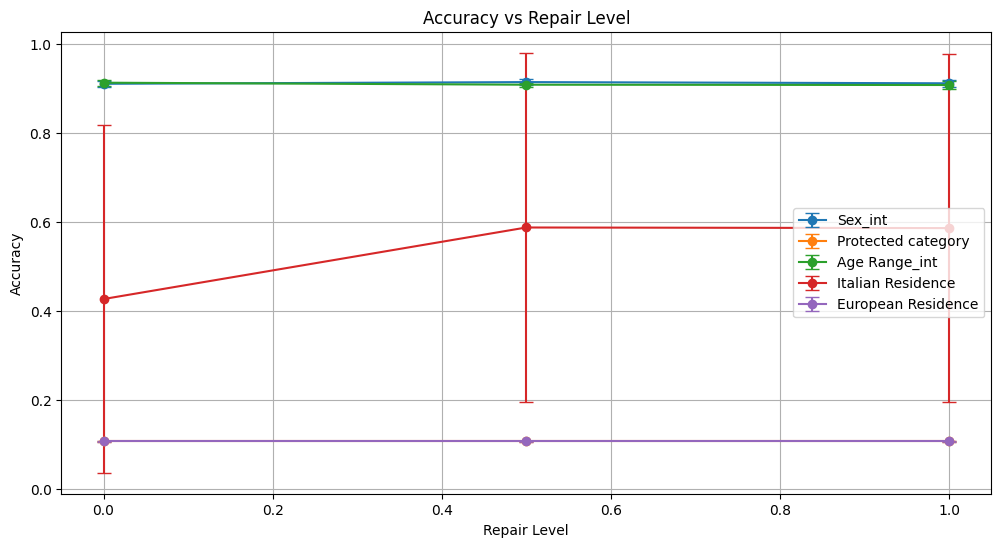

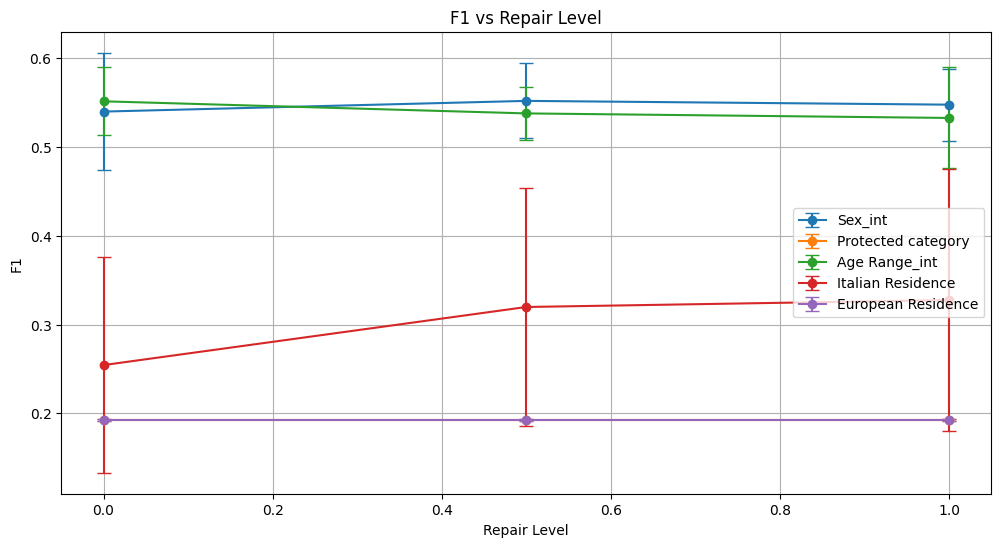

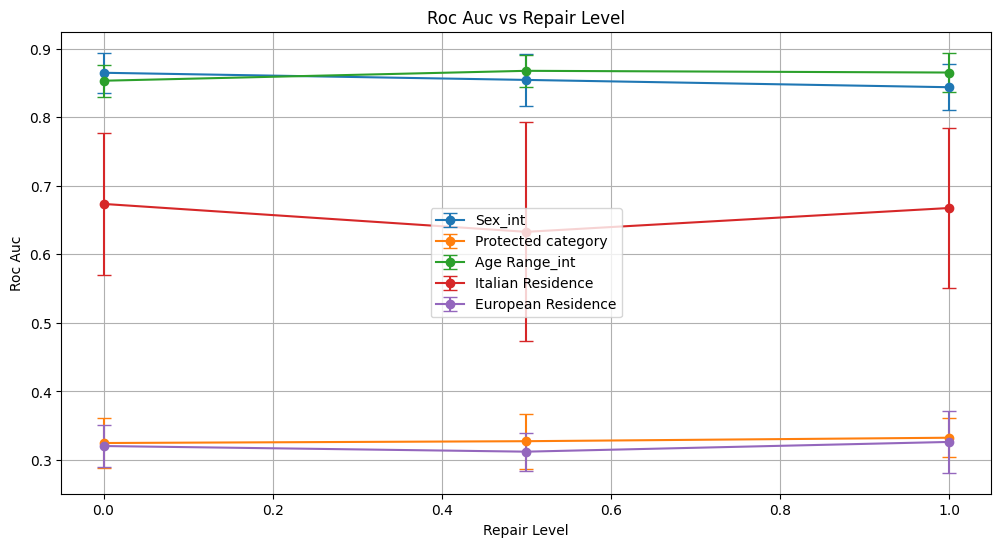

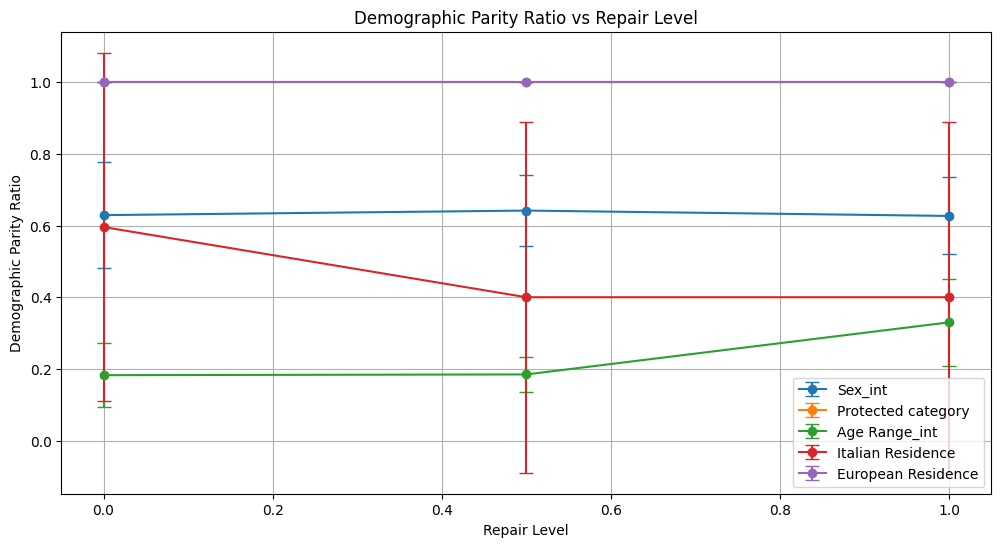

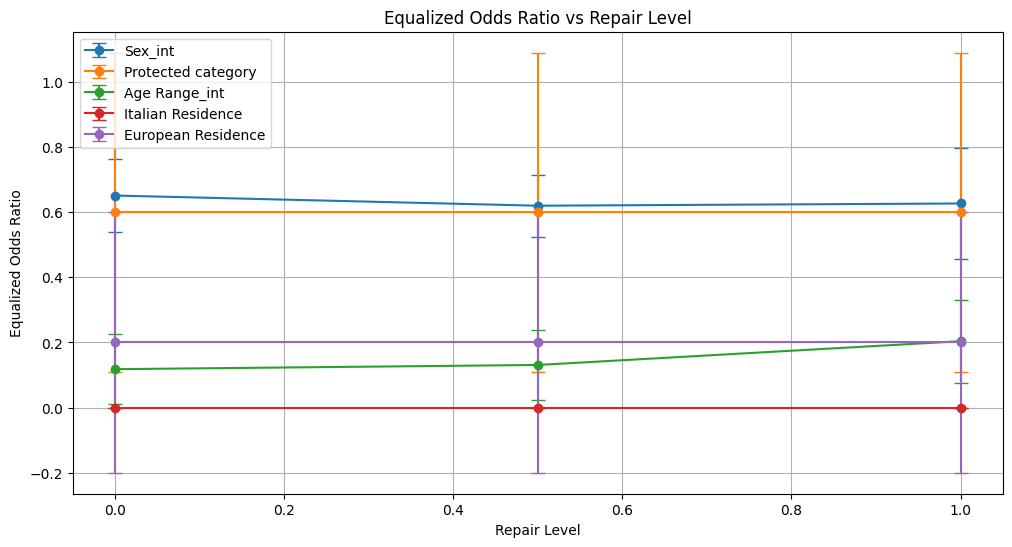

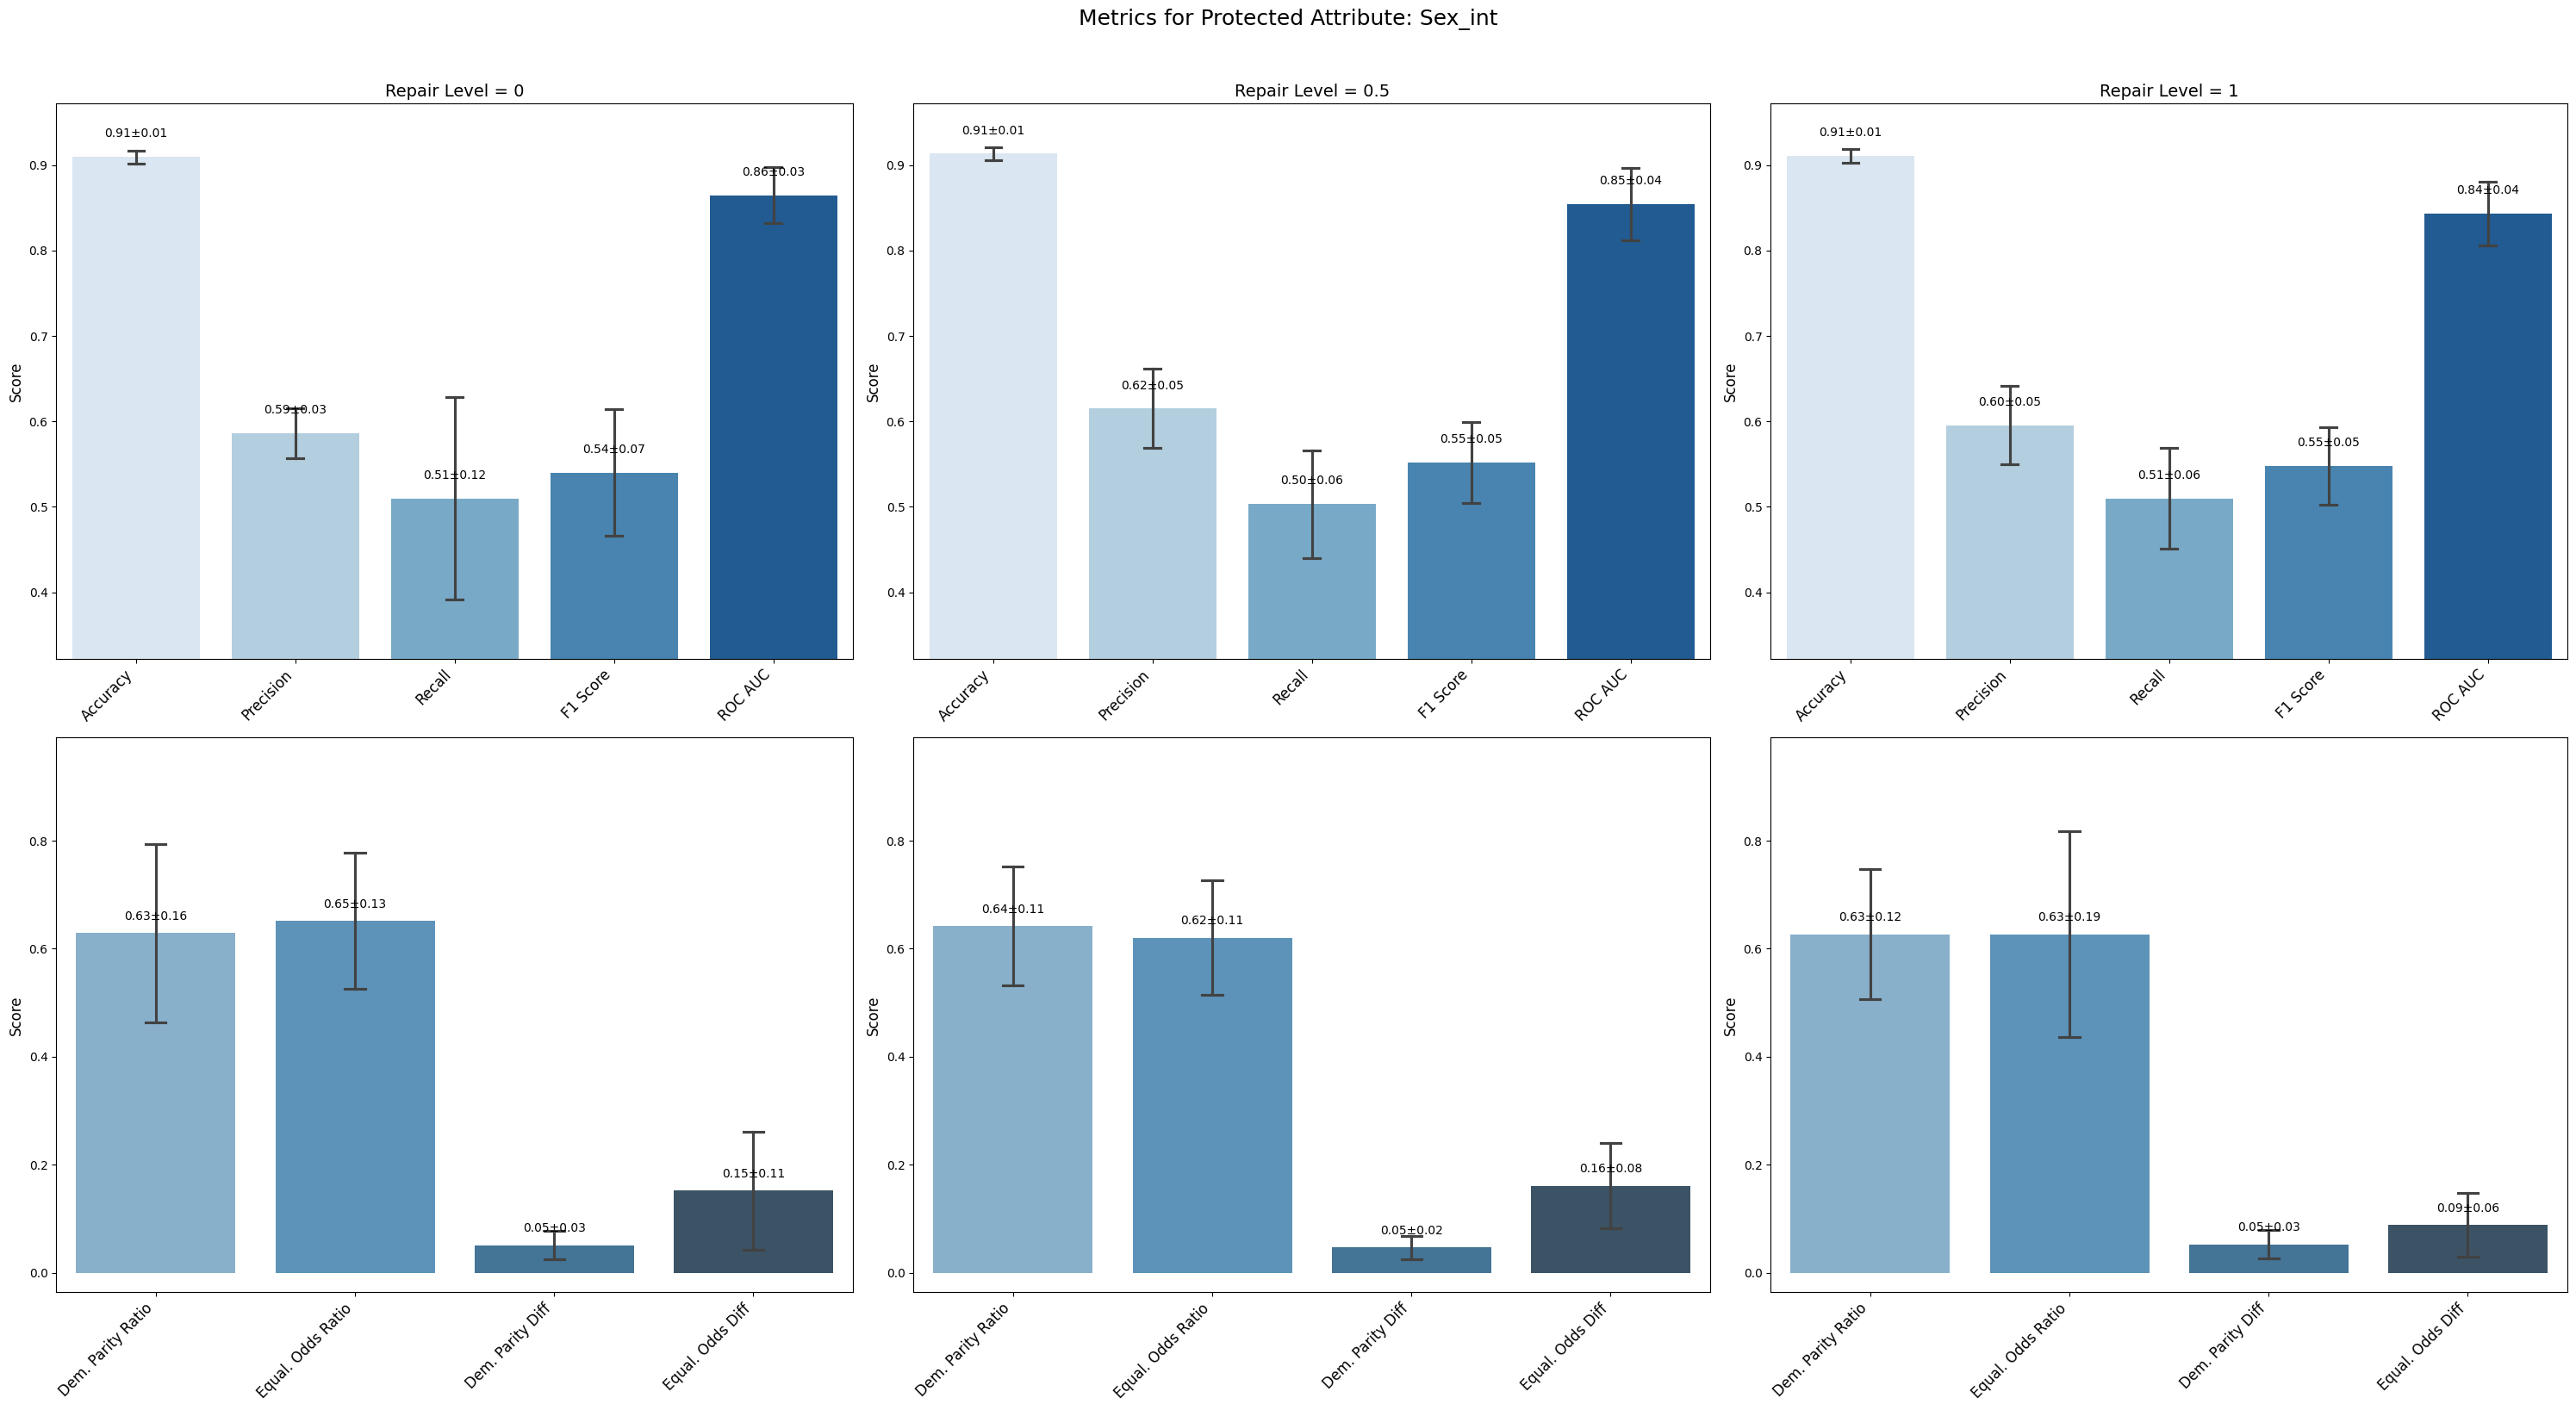

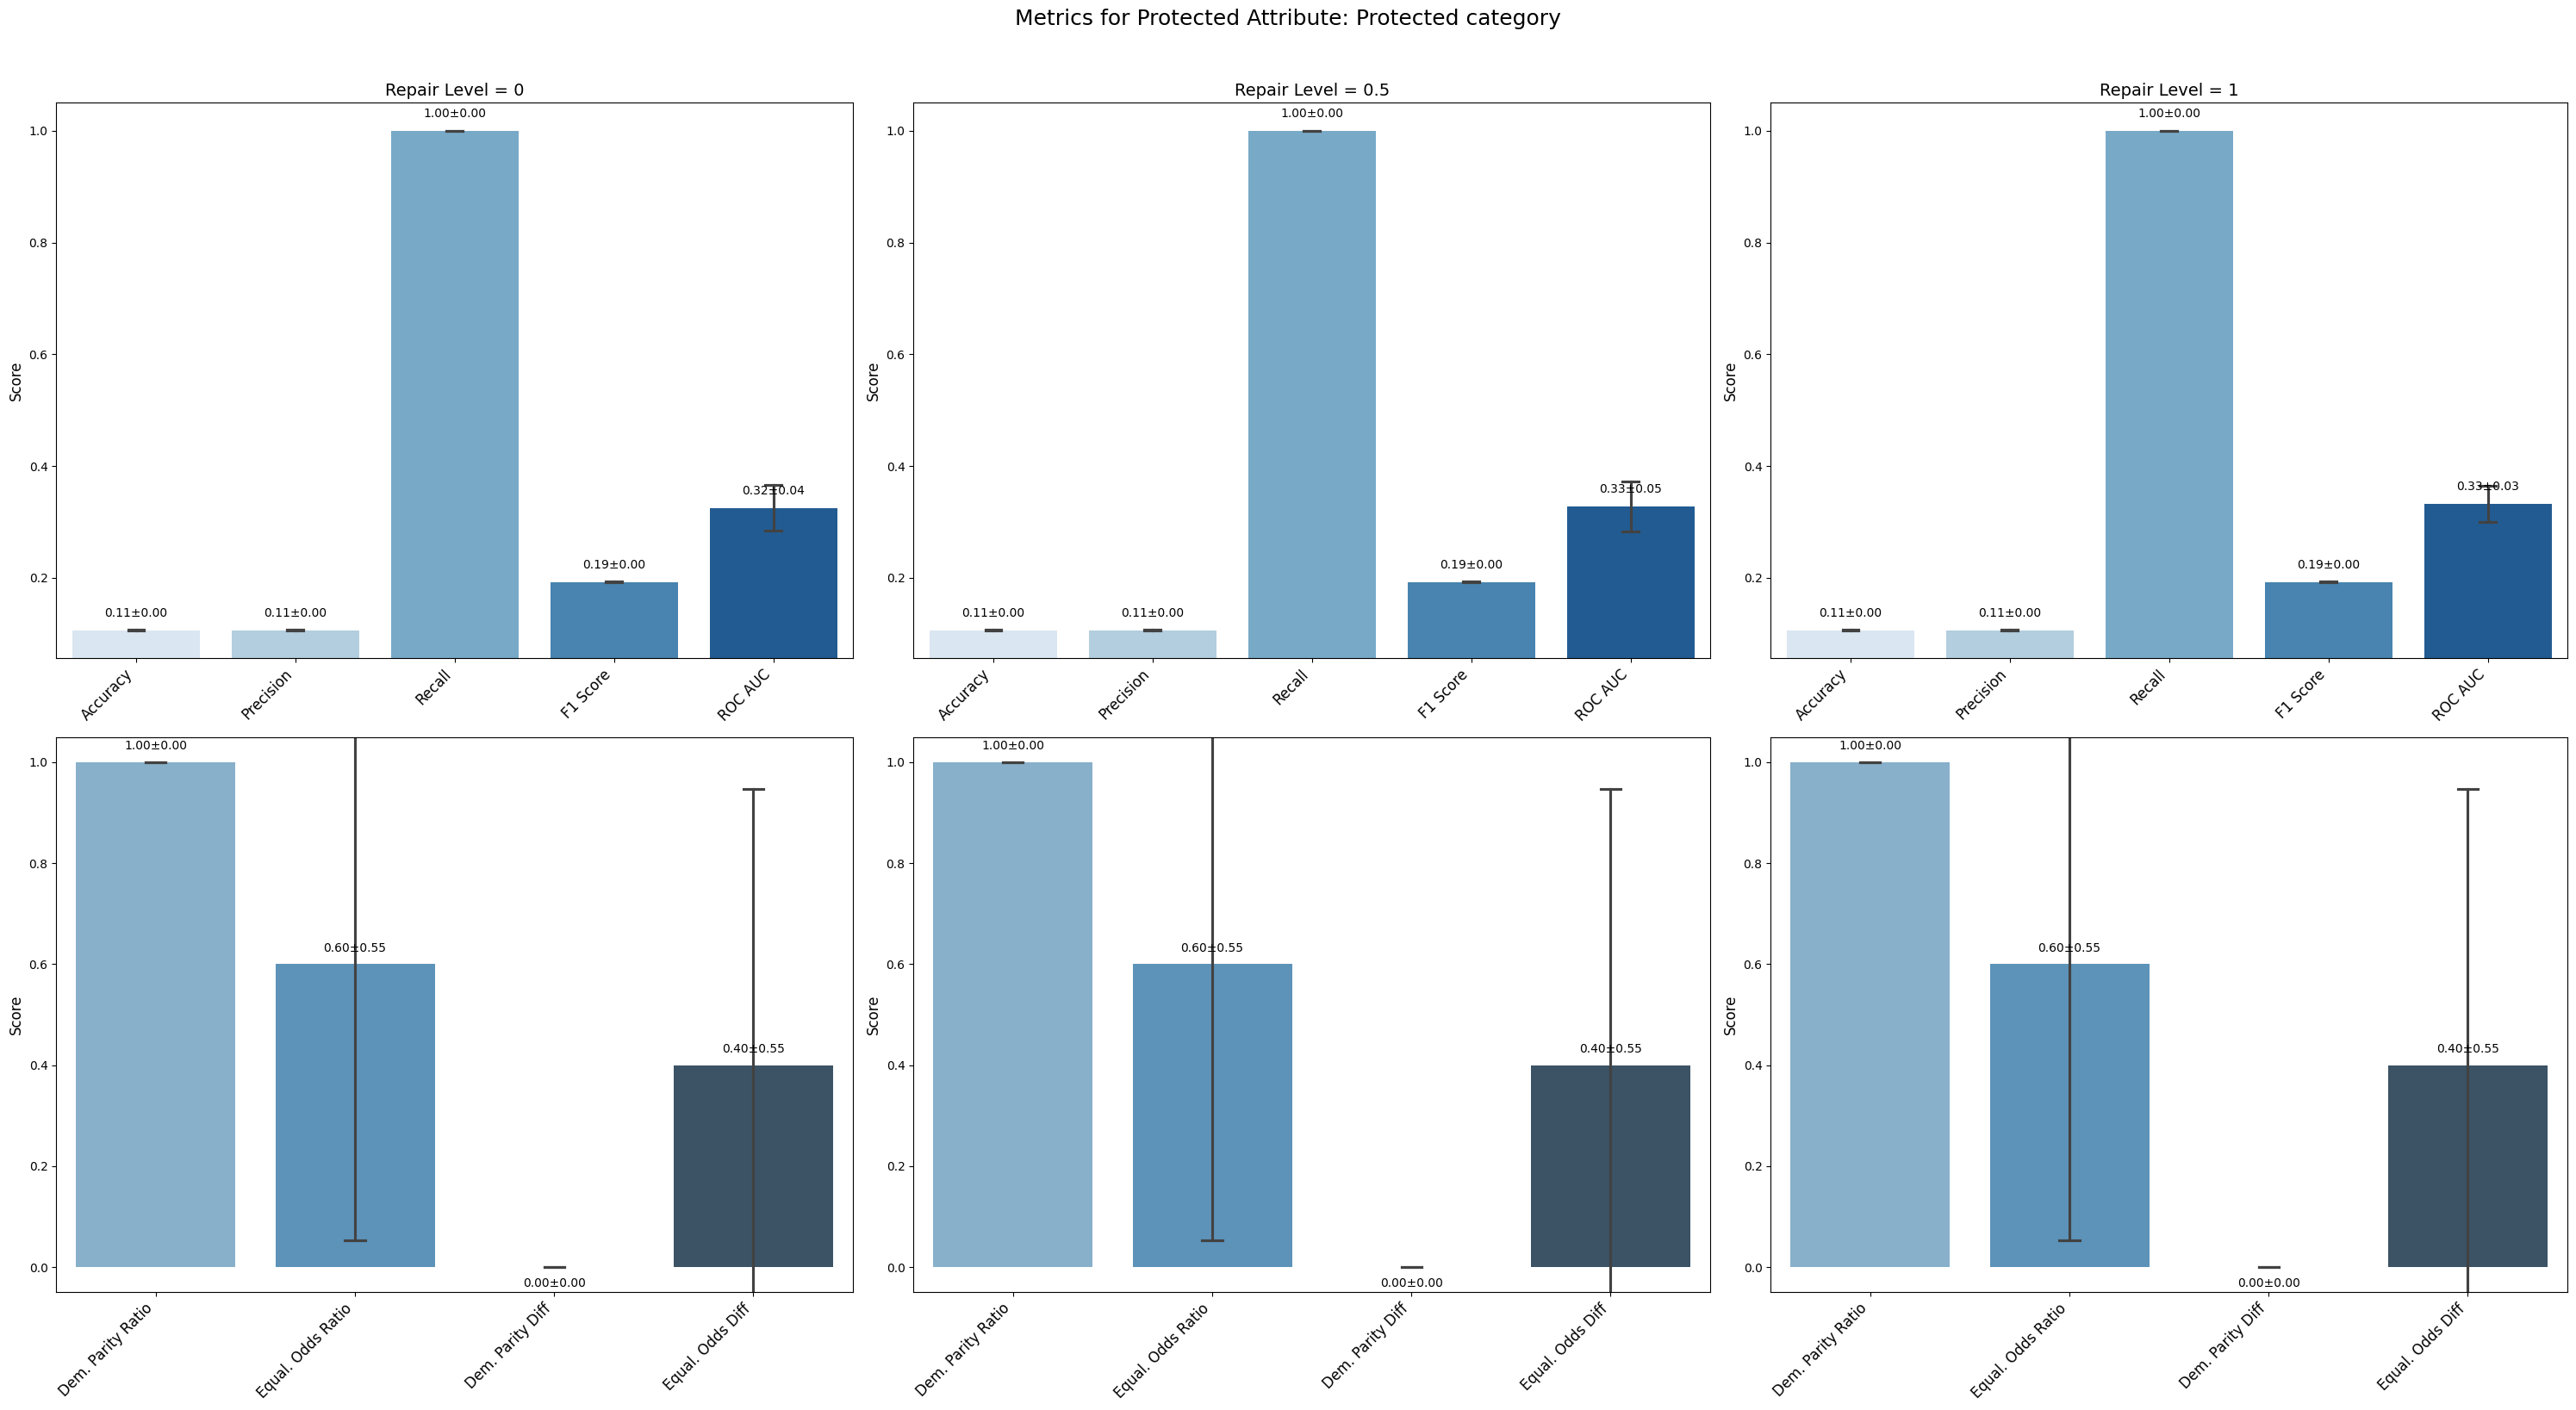

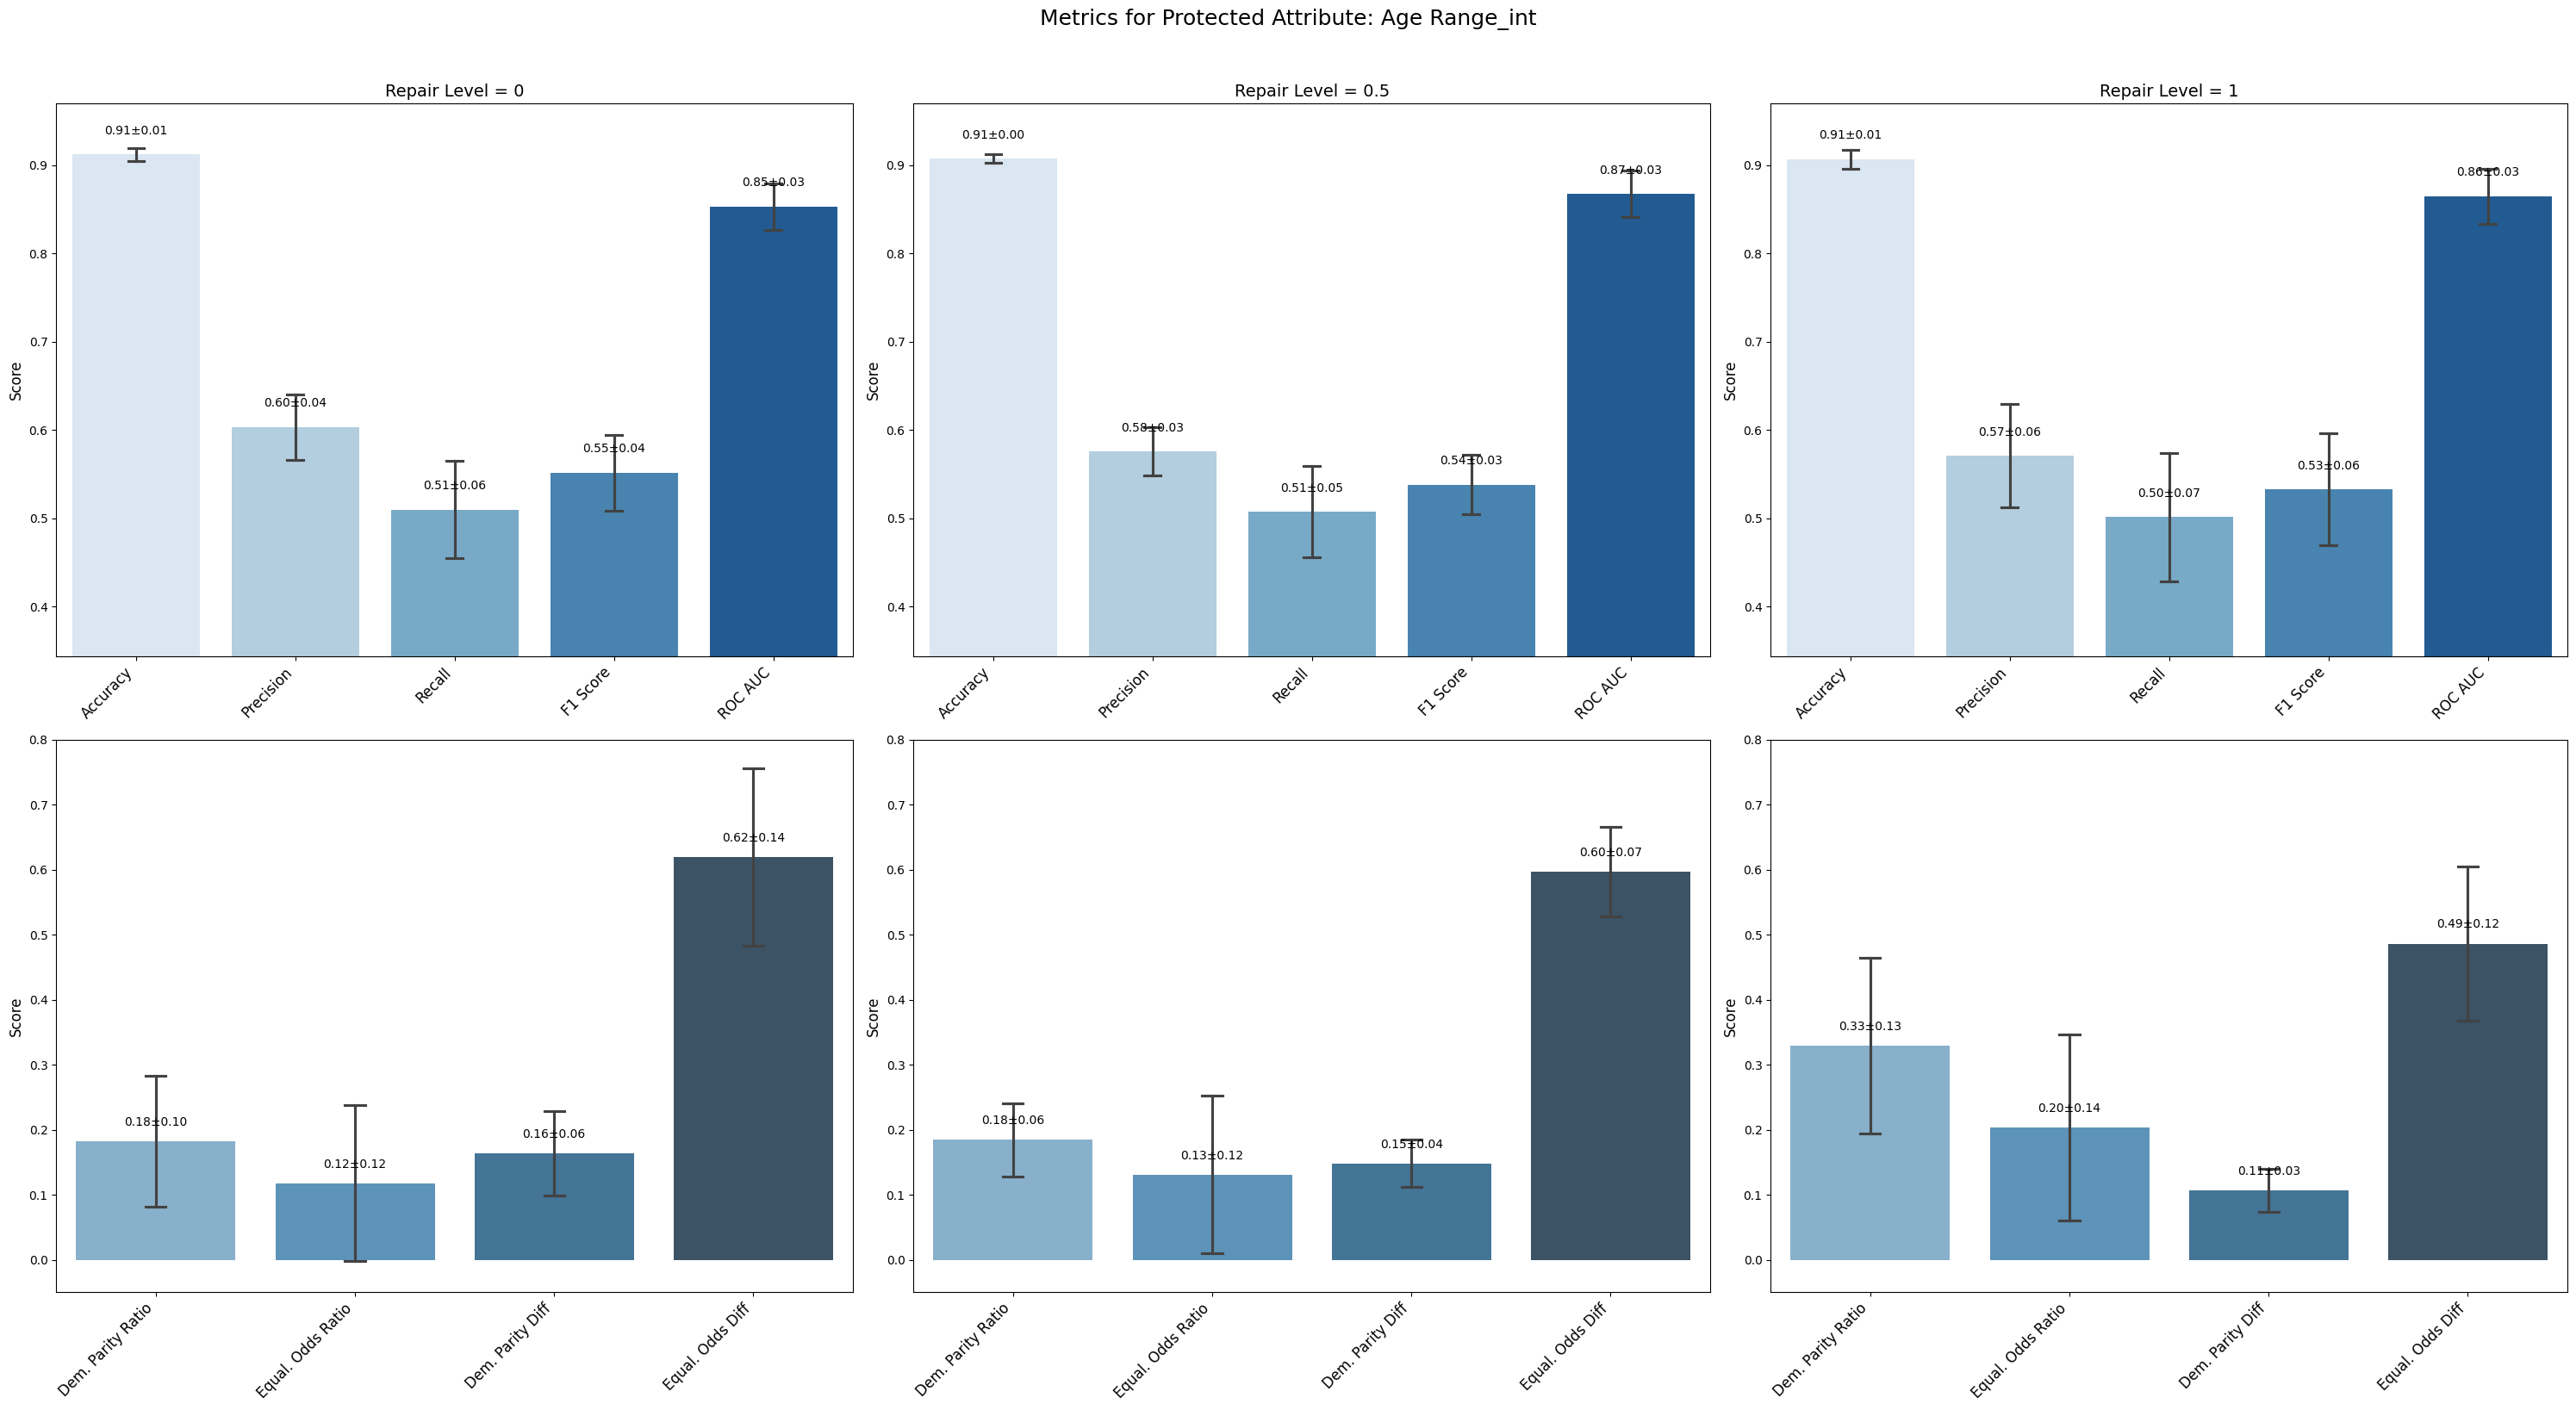

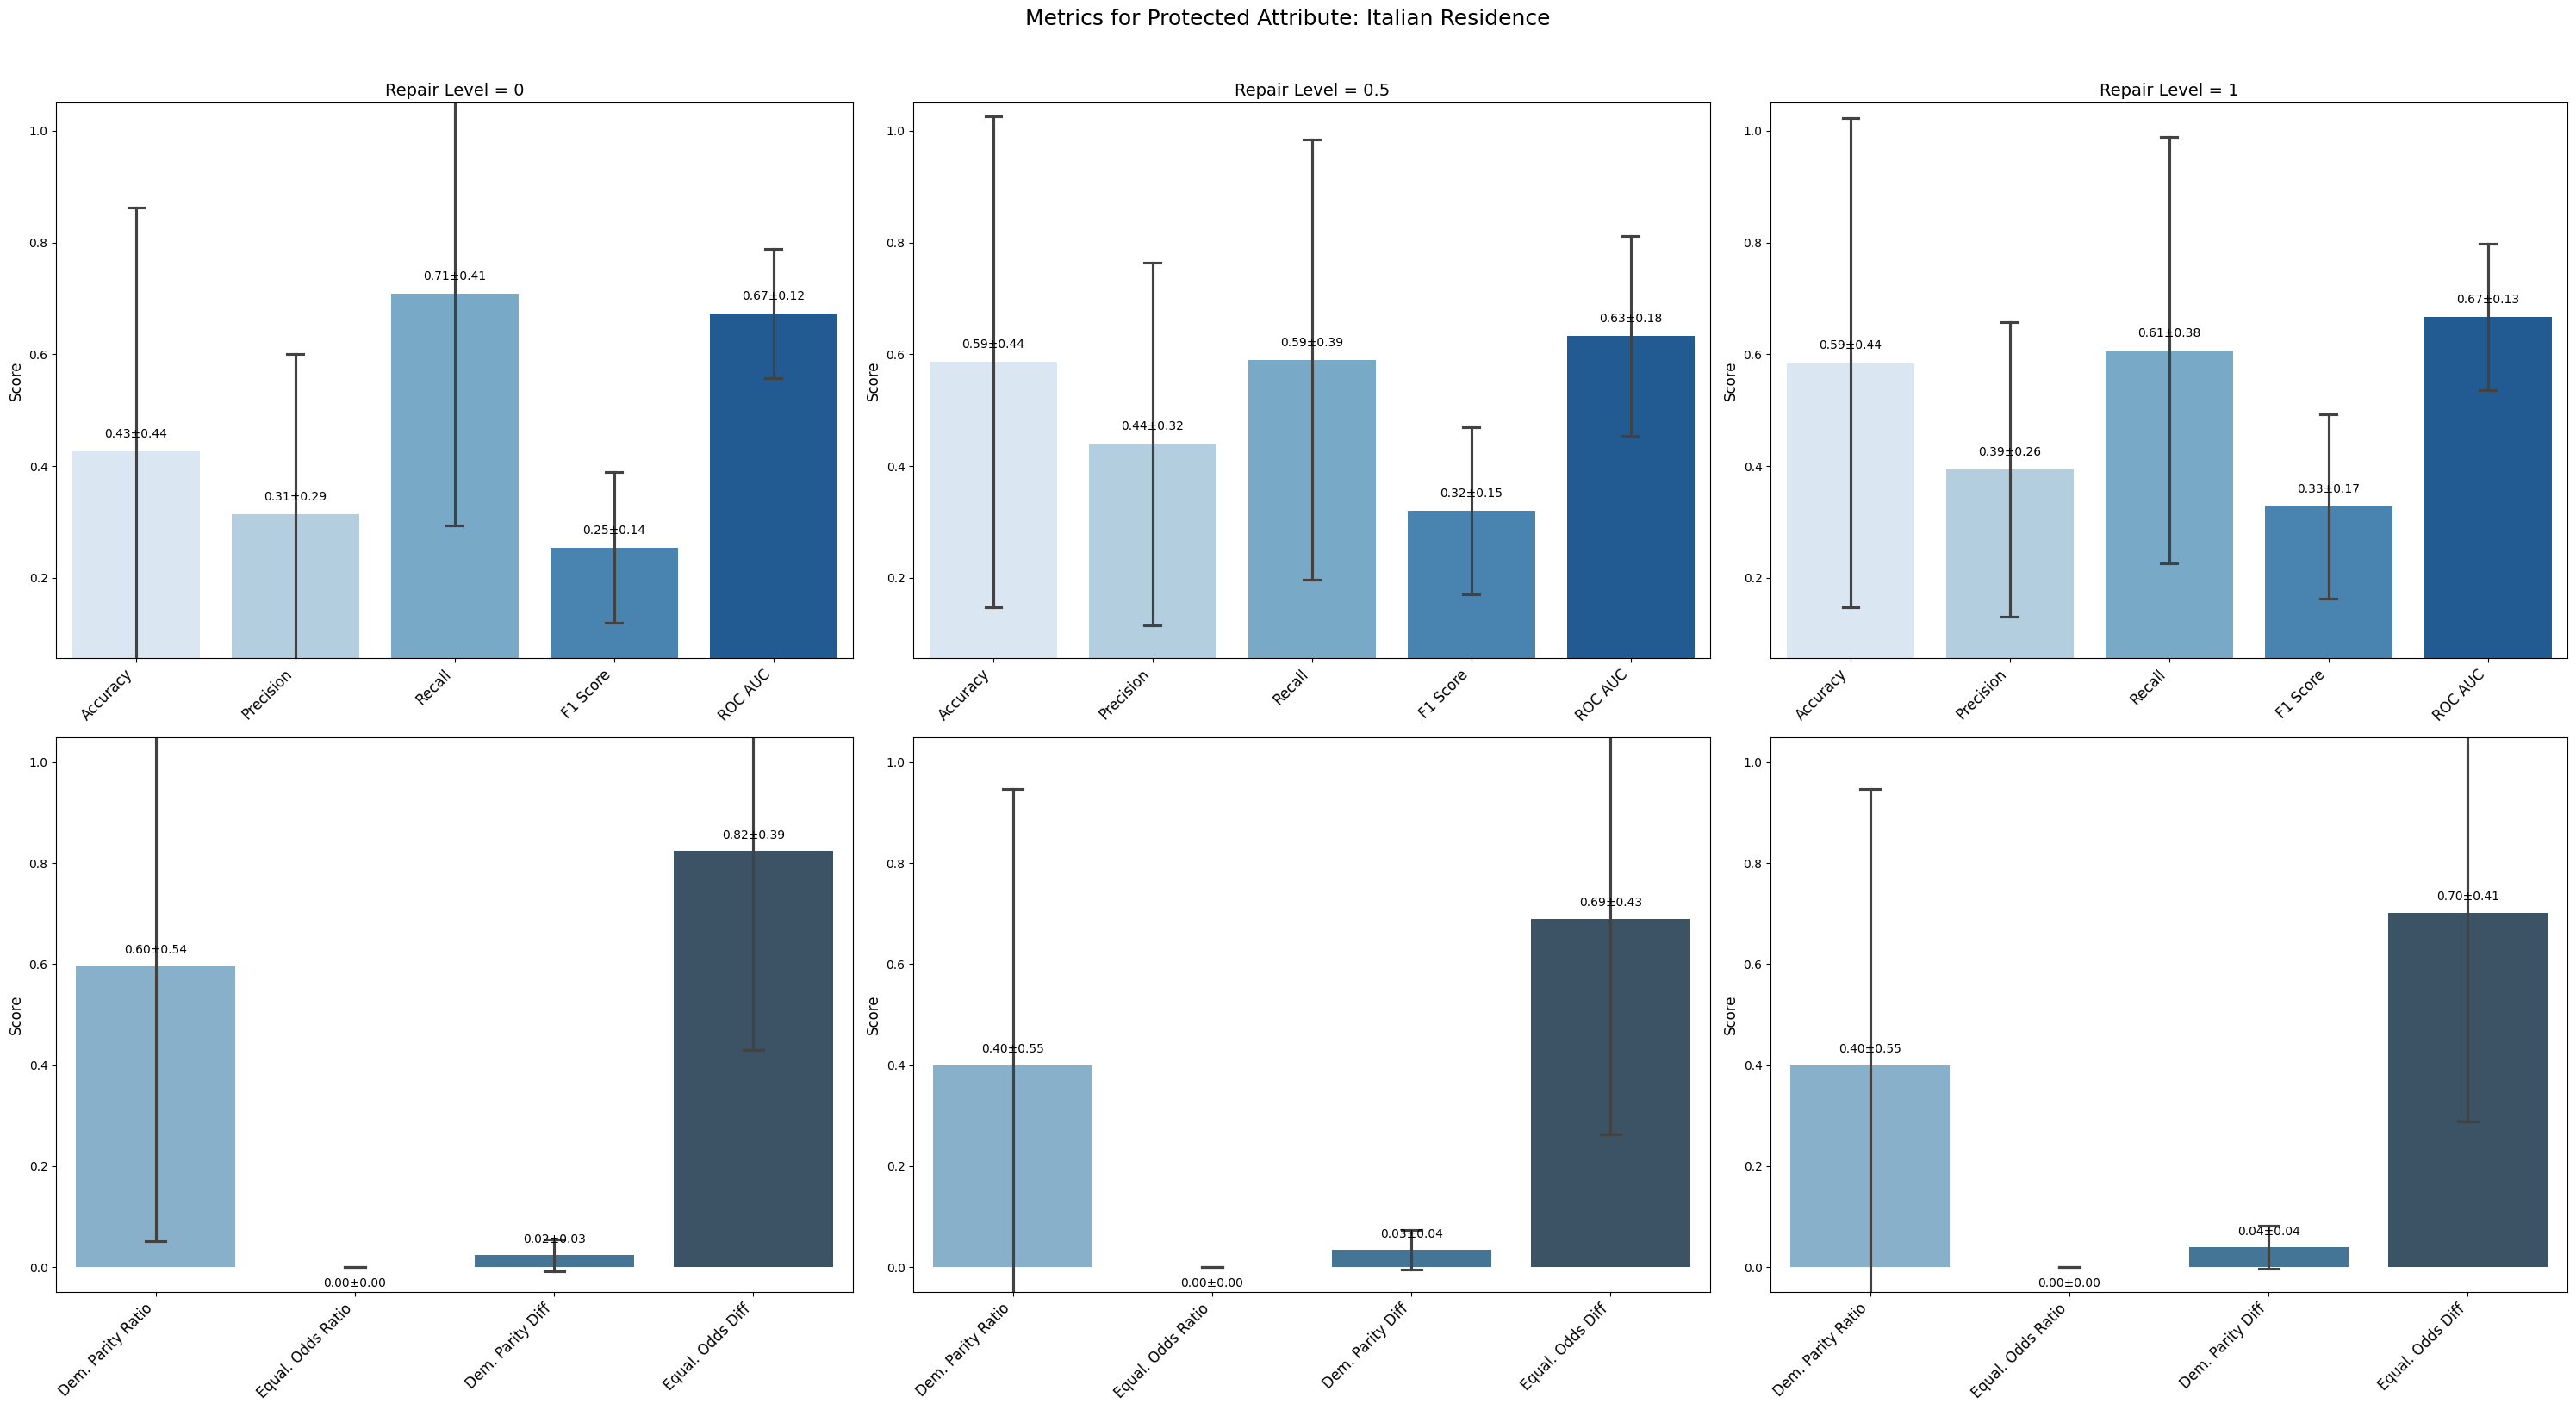

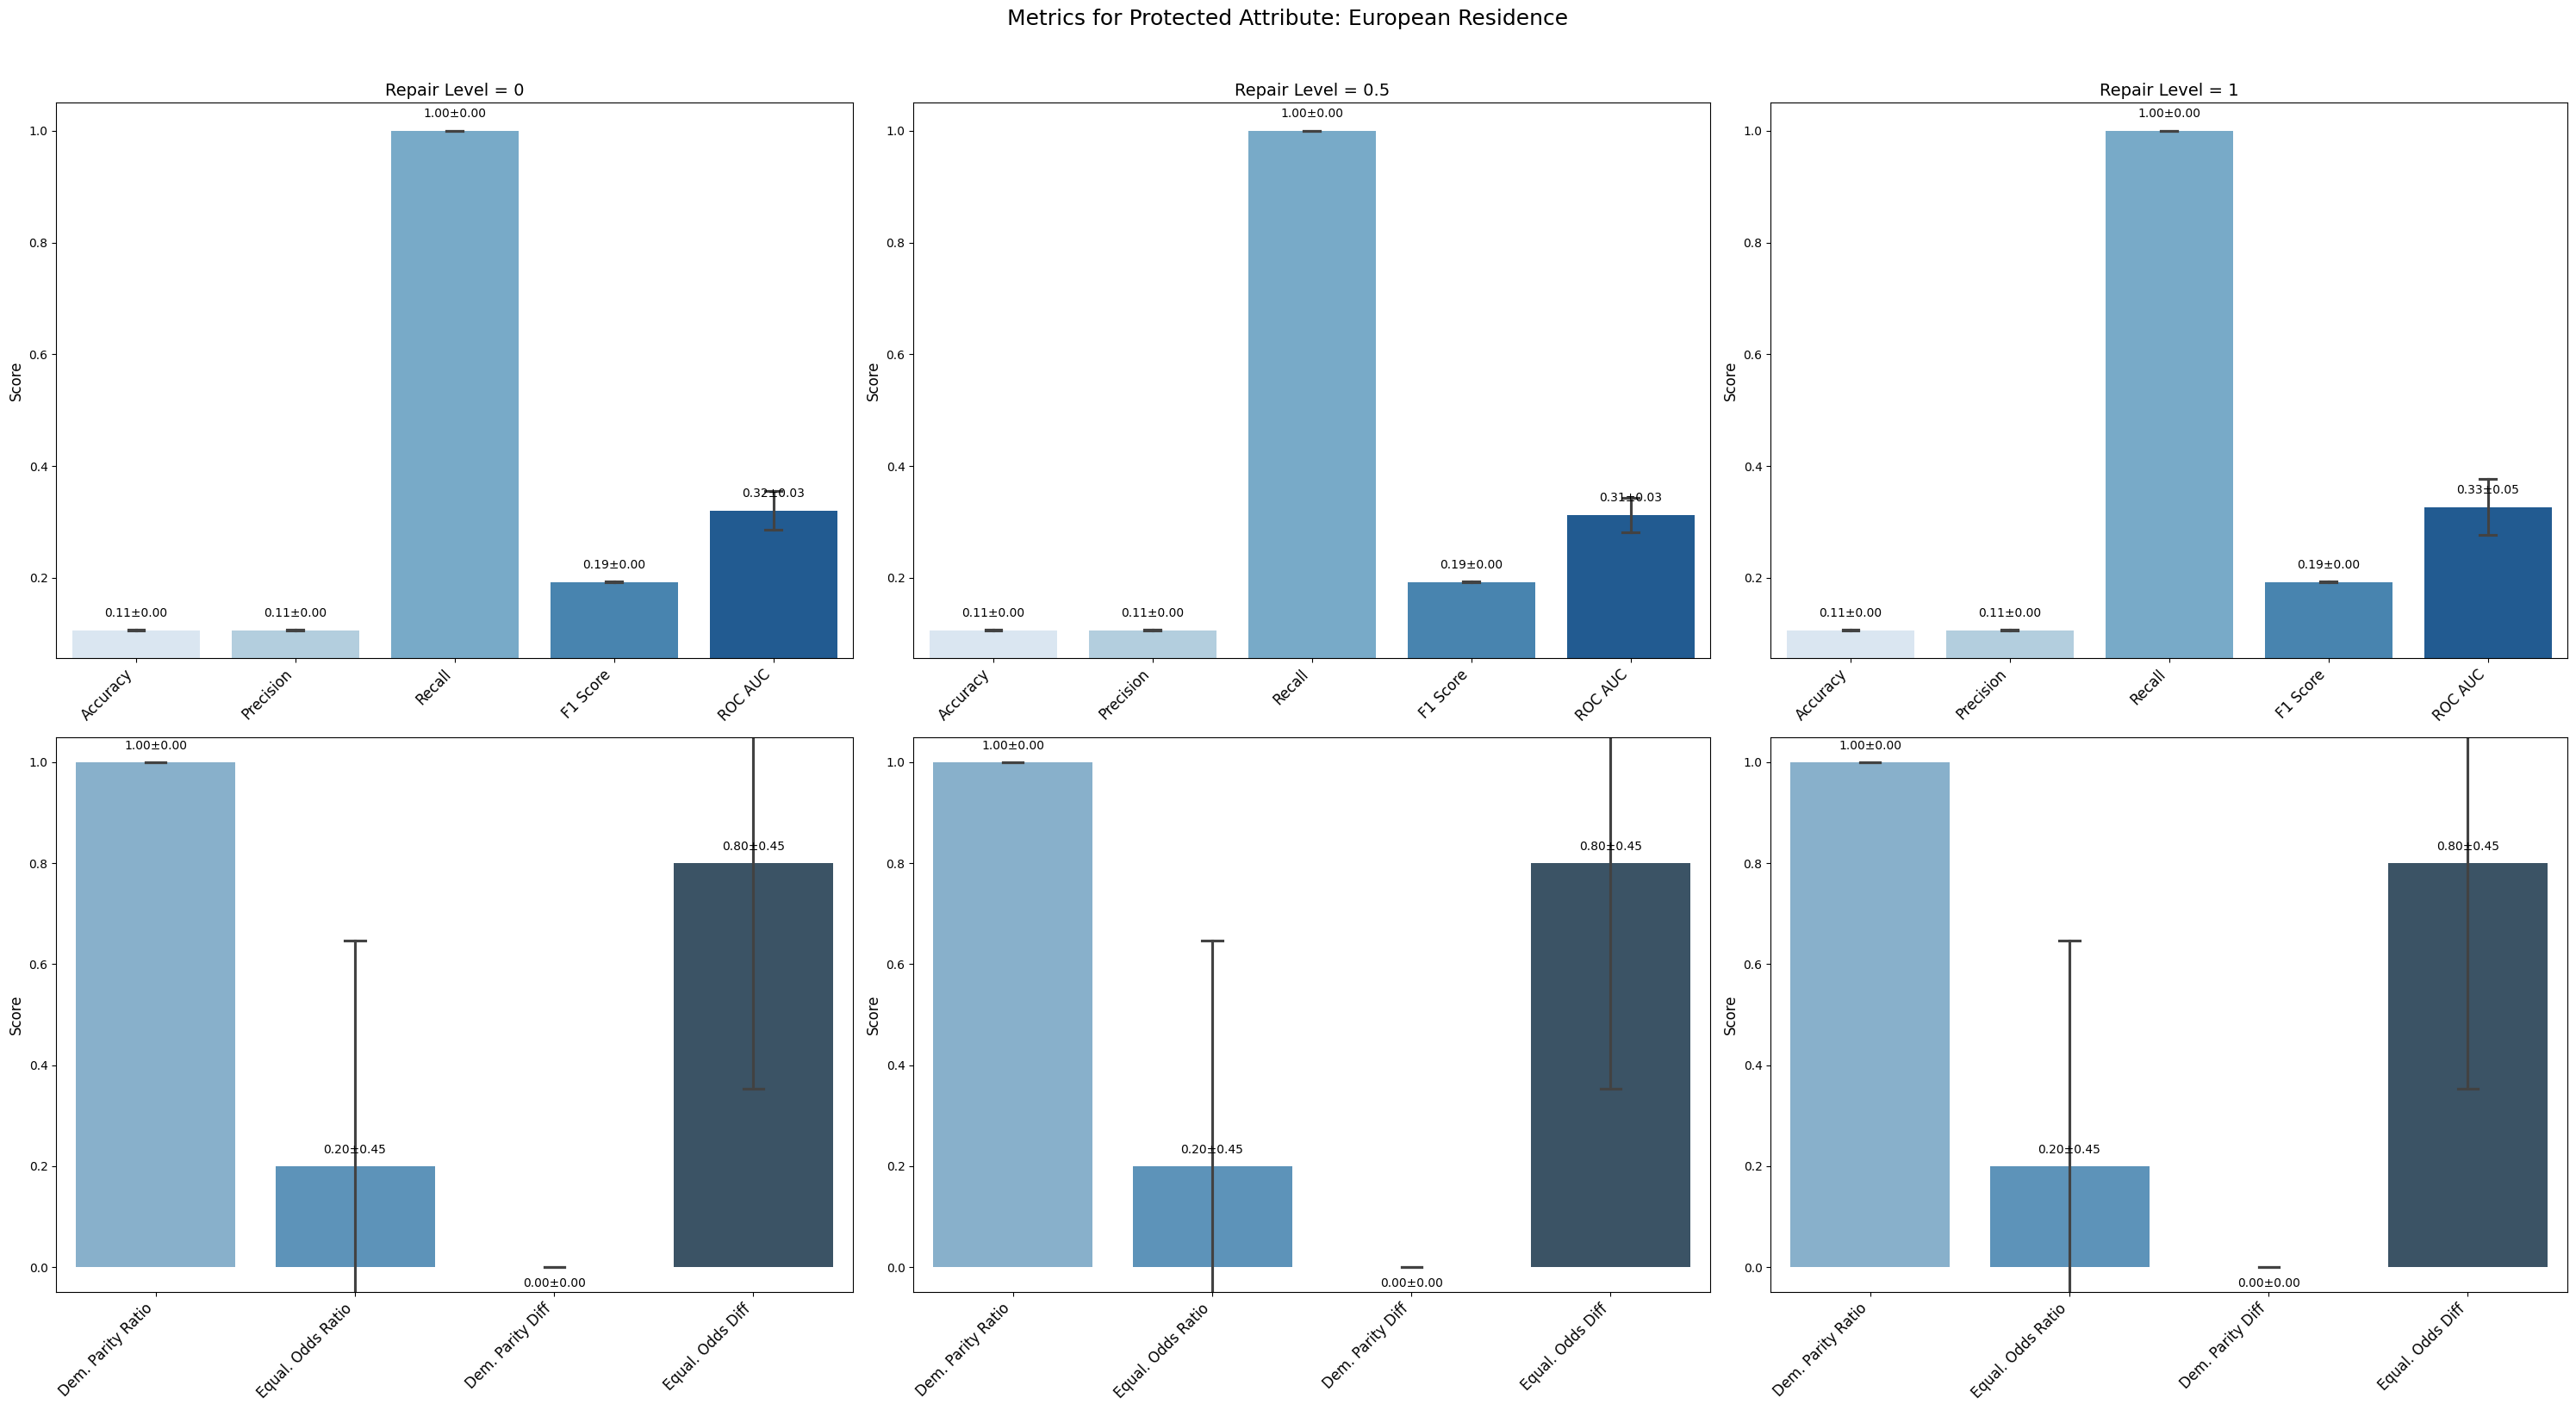

In [31]:
for metric in ['accuracy', 'f1', 'roc_auc', 'demographic_parity_ratio', 'equalized_odds_ratio']:
    plot_metrics(plot_data, metric, repair_levels, protected_attributes)

plot_metrics_grouped(results, 
                     protected_attributes=protected_attributes, 
                     repair_levels=repair_levels)

## Prejudice Remover

In [32]:
results = defaultdict(list)  
plot_data = defaultdict(dict)  

for fold, (train_idx, test_idx) in tqdm(enumerate(kf.split(dataset, dataset['Hired'])), total=n_folds, desc='Folds...'):
    train_df = dataset.iloc[train_idx].copy()
    test_df = dataset.iloc[test_idx].copy()

    imputer = SimpleImputer(strategy='mean')
    train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)
    test_df = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)
    
    train_df = DataFrame(train_df)
    test_df = DataFrame(test_df)
    
    scaler = StandardScaler()
    train_df[non_bool_cols] = scaler.fit_transform(train_df[non_bool_cols])
    test_df[non_bool_cols] = scaler.transform(test_df[non_bool_cols])
    
    for sensitive_attr in protected_attributes:
        for repair_level in repair_levels:
            train_df.sensitive = sensitive_attr
            train_df.targets = 'Hired'
            test_df.sensitive = sensitive_attr
            test_df.targets = 'Hired'
            
            base_model = base_model_lambda()
            
            model = PrejudiceRemover(
                torchModel=base_model,
                weight=repair_level  
            )
            
            model.fit(train_df[features], train_df[['Hired']], num_epochs=20, batch_size=32)
            train_probs = model.predict(train_df[features]).numpy()

            thresholds = np.linspace(0, 1, 101)
            best_threshold = 0.5
            best_f1 = 0.0
            y_train_true = train_df[['Hired']].values

            for thresh in thresholds:
                train_preds = (train_probs > thresh).astype(int)
                f1 = f1_score(y_train_true, train_preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = thresh

            y_pred = model.predict(test_df[features])
            y_prob = y_pred.numpy()  
            
            y_pred_binary = (y_prob > best_threshold).astype(int)
            
            y_test = test_df[['Hired']].values
            metrics = {
                'accuracy': accuracy_score(y_test, y_pred_binary),
                'precision': precision_score(y_test, y_pred_binary, zero_division=0),
                'recall': recall_score(y_test, y_pred_binary, zero_division=0),
                'f1': f1_score(y_test, y_pred_binary, zero_division=0),
                'roc_auc': roc_auc_score(y_test, y_prob),
                'demographic_parity_ratio': demographic_parity_ratio(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
                'equalized_odds_ratio': equalized_odds_ratio(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
                'demographic_parity_difference': demographic_parity_difference(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
                'equalized_odds_difference': equalized_odds_difference(
                    y_test, y_pred_binary, sensitive_features=test_df[sensitive_attr]),
            }

            key = f"{sensitive_attr}_repair_{repair_level}"
            results[key].append(metrics)

metrics_keys = list(metrics.keys())  
for sensitive_attr in protected_attributes:
    for repair_level in repair_levels:
        key = f"{sensitive_attr}_repair_{repair_level}"
        fold_metrics = results.get(key, [])

        for metric in metrics_keys:
            metric_list = [m[metric] for m in fold_metrics]
            mean, std = get_mean_std(metric_list)
            plot_data[sensitive_attr][f"{metric}_mean_{repair_level}"] = mean
            plot_data[sensitive_attr][f"{metric}_std_{repair_level}"] = std

Folds...: 100%|██████████| 5/5 [24:55<00:00, 299.09s/it]


In [33]:
print_fairness_results_table(plot_data, metrics_keys, repair_levels)


=== Results for sensitive attribute: Sex_int ===

                                    Repair 0     Repair 0.5       Repair 1
accuracy                       0.907 ± 0.001  0.909 ± 0.005  0.914 ± 0.004
precision                      0.567 ± 0.014  0.574 ± 0.018  0.605 ± 0.020
recall                         0.543 ± 0.061  0.573 ± 0.071  0.548 ± 0.025
f1                             0.552 ± 0.027  0.572 ± 0.039  0.574 ± 0.019
roc_auc                        0.886 ± 0.015  0.897 ± 0.020  0.889 ± 0.016
demographic_parity_ratio       0.693 ± 0.134  0.668 ± 0.150  0.572 ± 0.126
equalized_odds_ratio           0.778 ± 0.150  0.729 ± 0.151  0.608 ± 0.141
demographic_parity_difference  0.043 ± 0.019  0.053 ± 0.030  0.066 ± 0.025
equalized_odds_difference      0.075 ± 0.071  0.103 ± 0.072  0.153 ± 0.046

=== Results for sensitive attribute: Protected category ===

                                    Repair 0     Repair 0.5       Repair 1
accuracy                       0.909 ± 0.005  0.911 ± 0.010  0

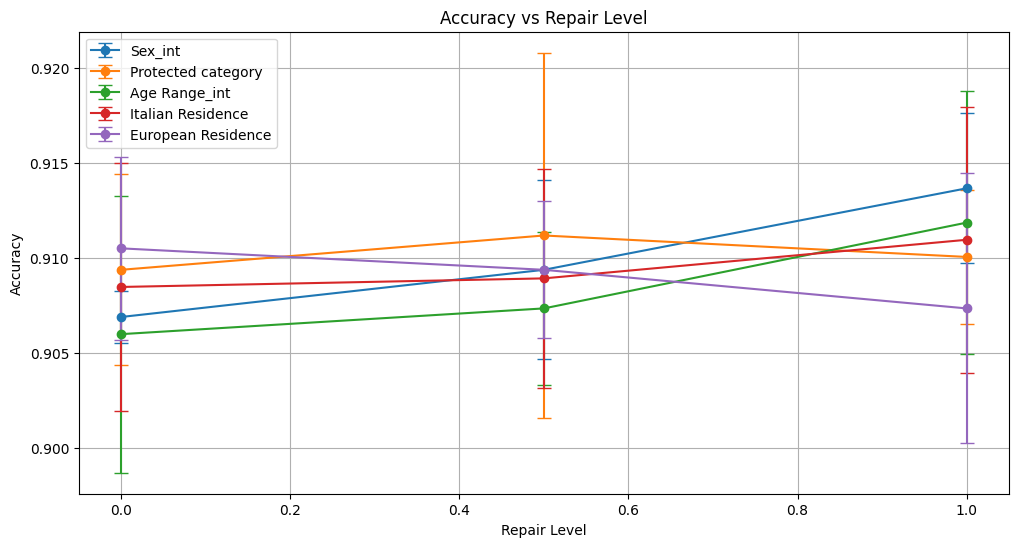

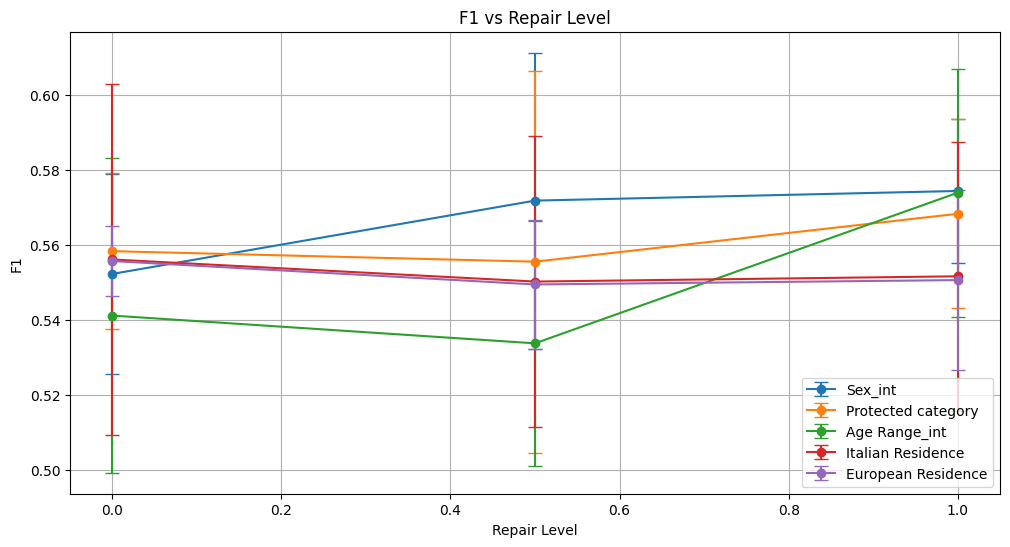

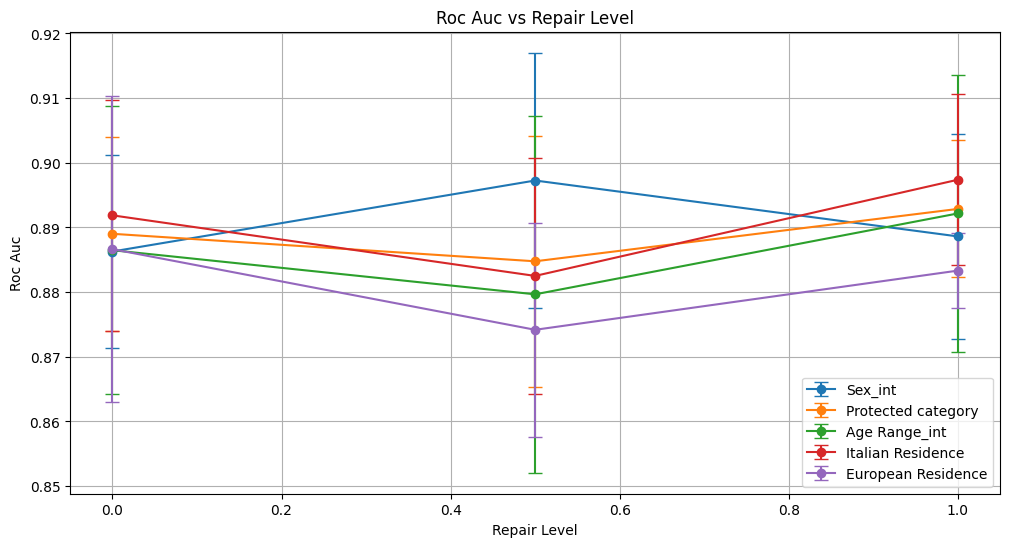

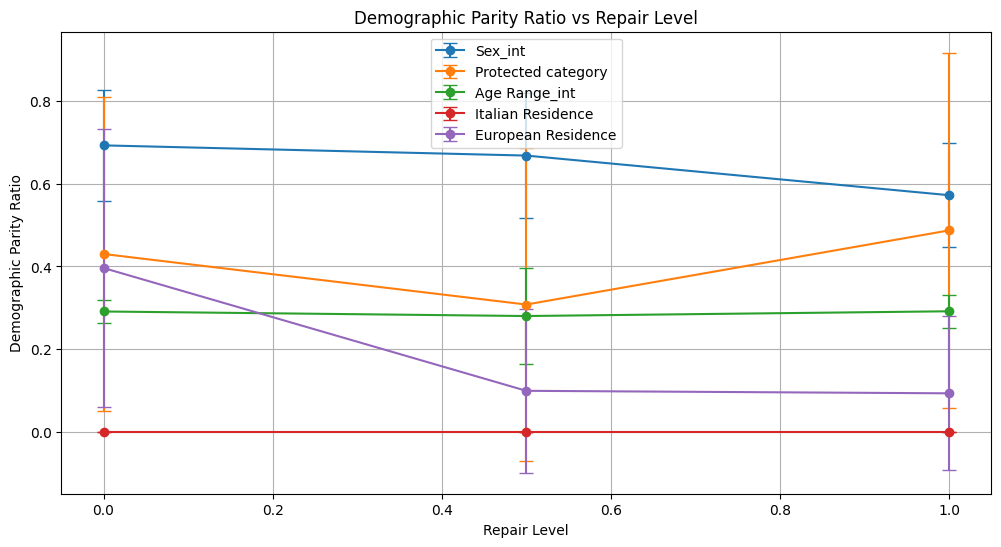

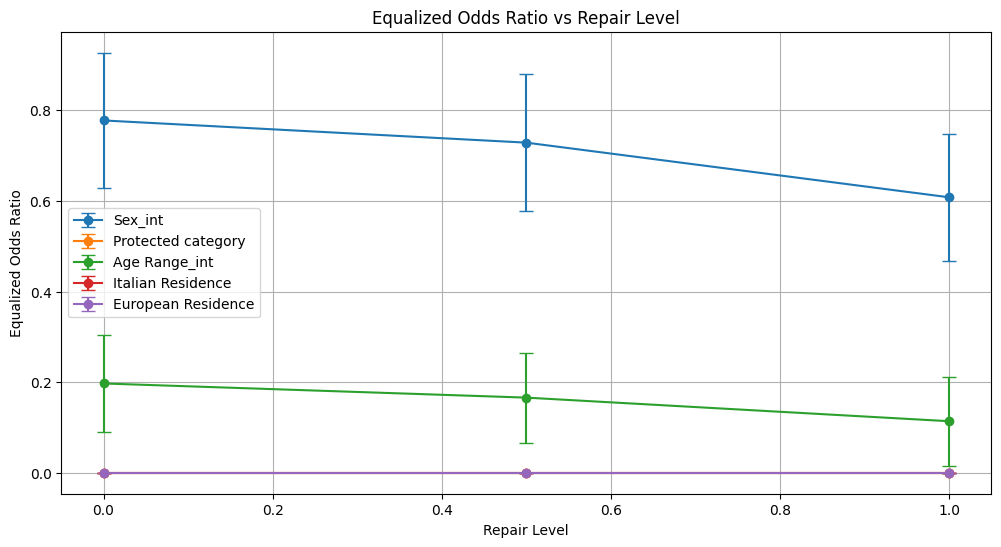

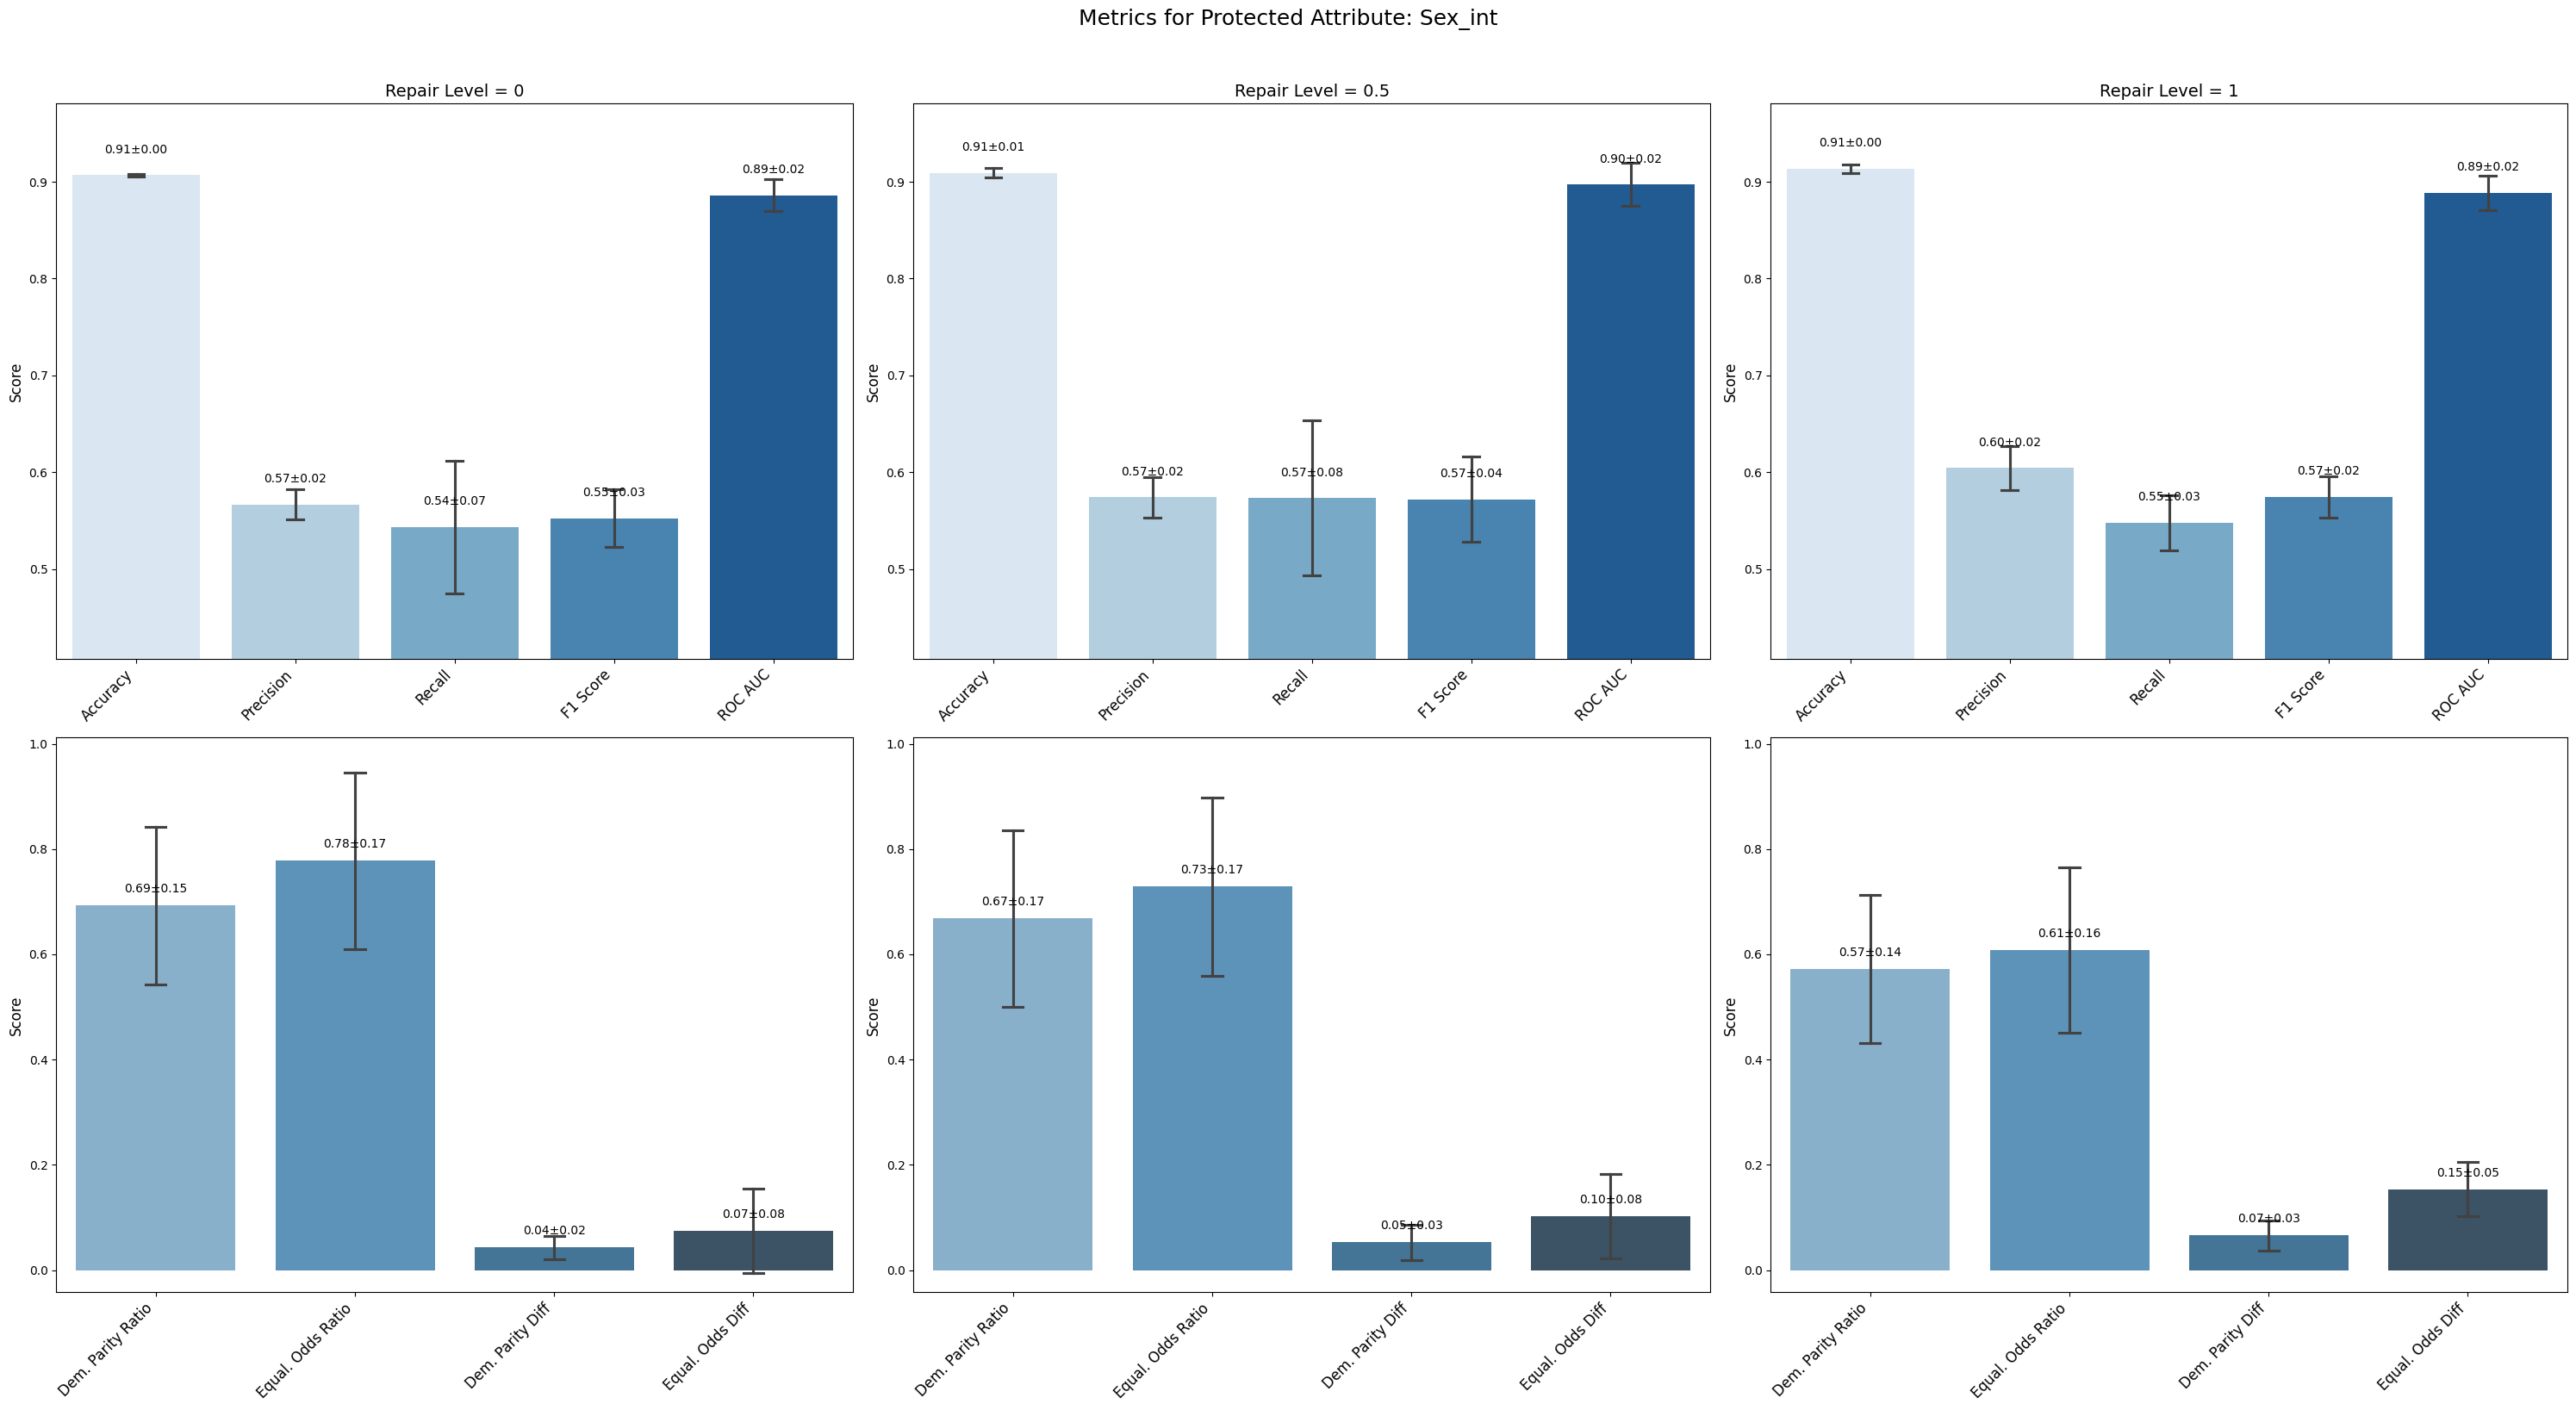

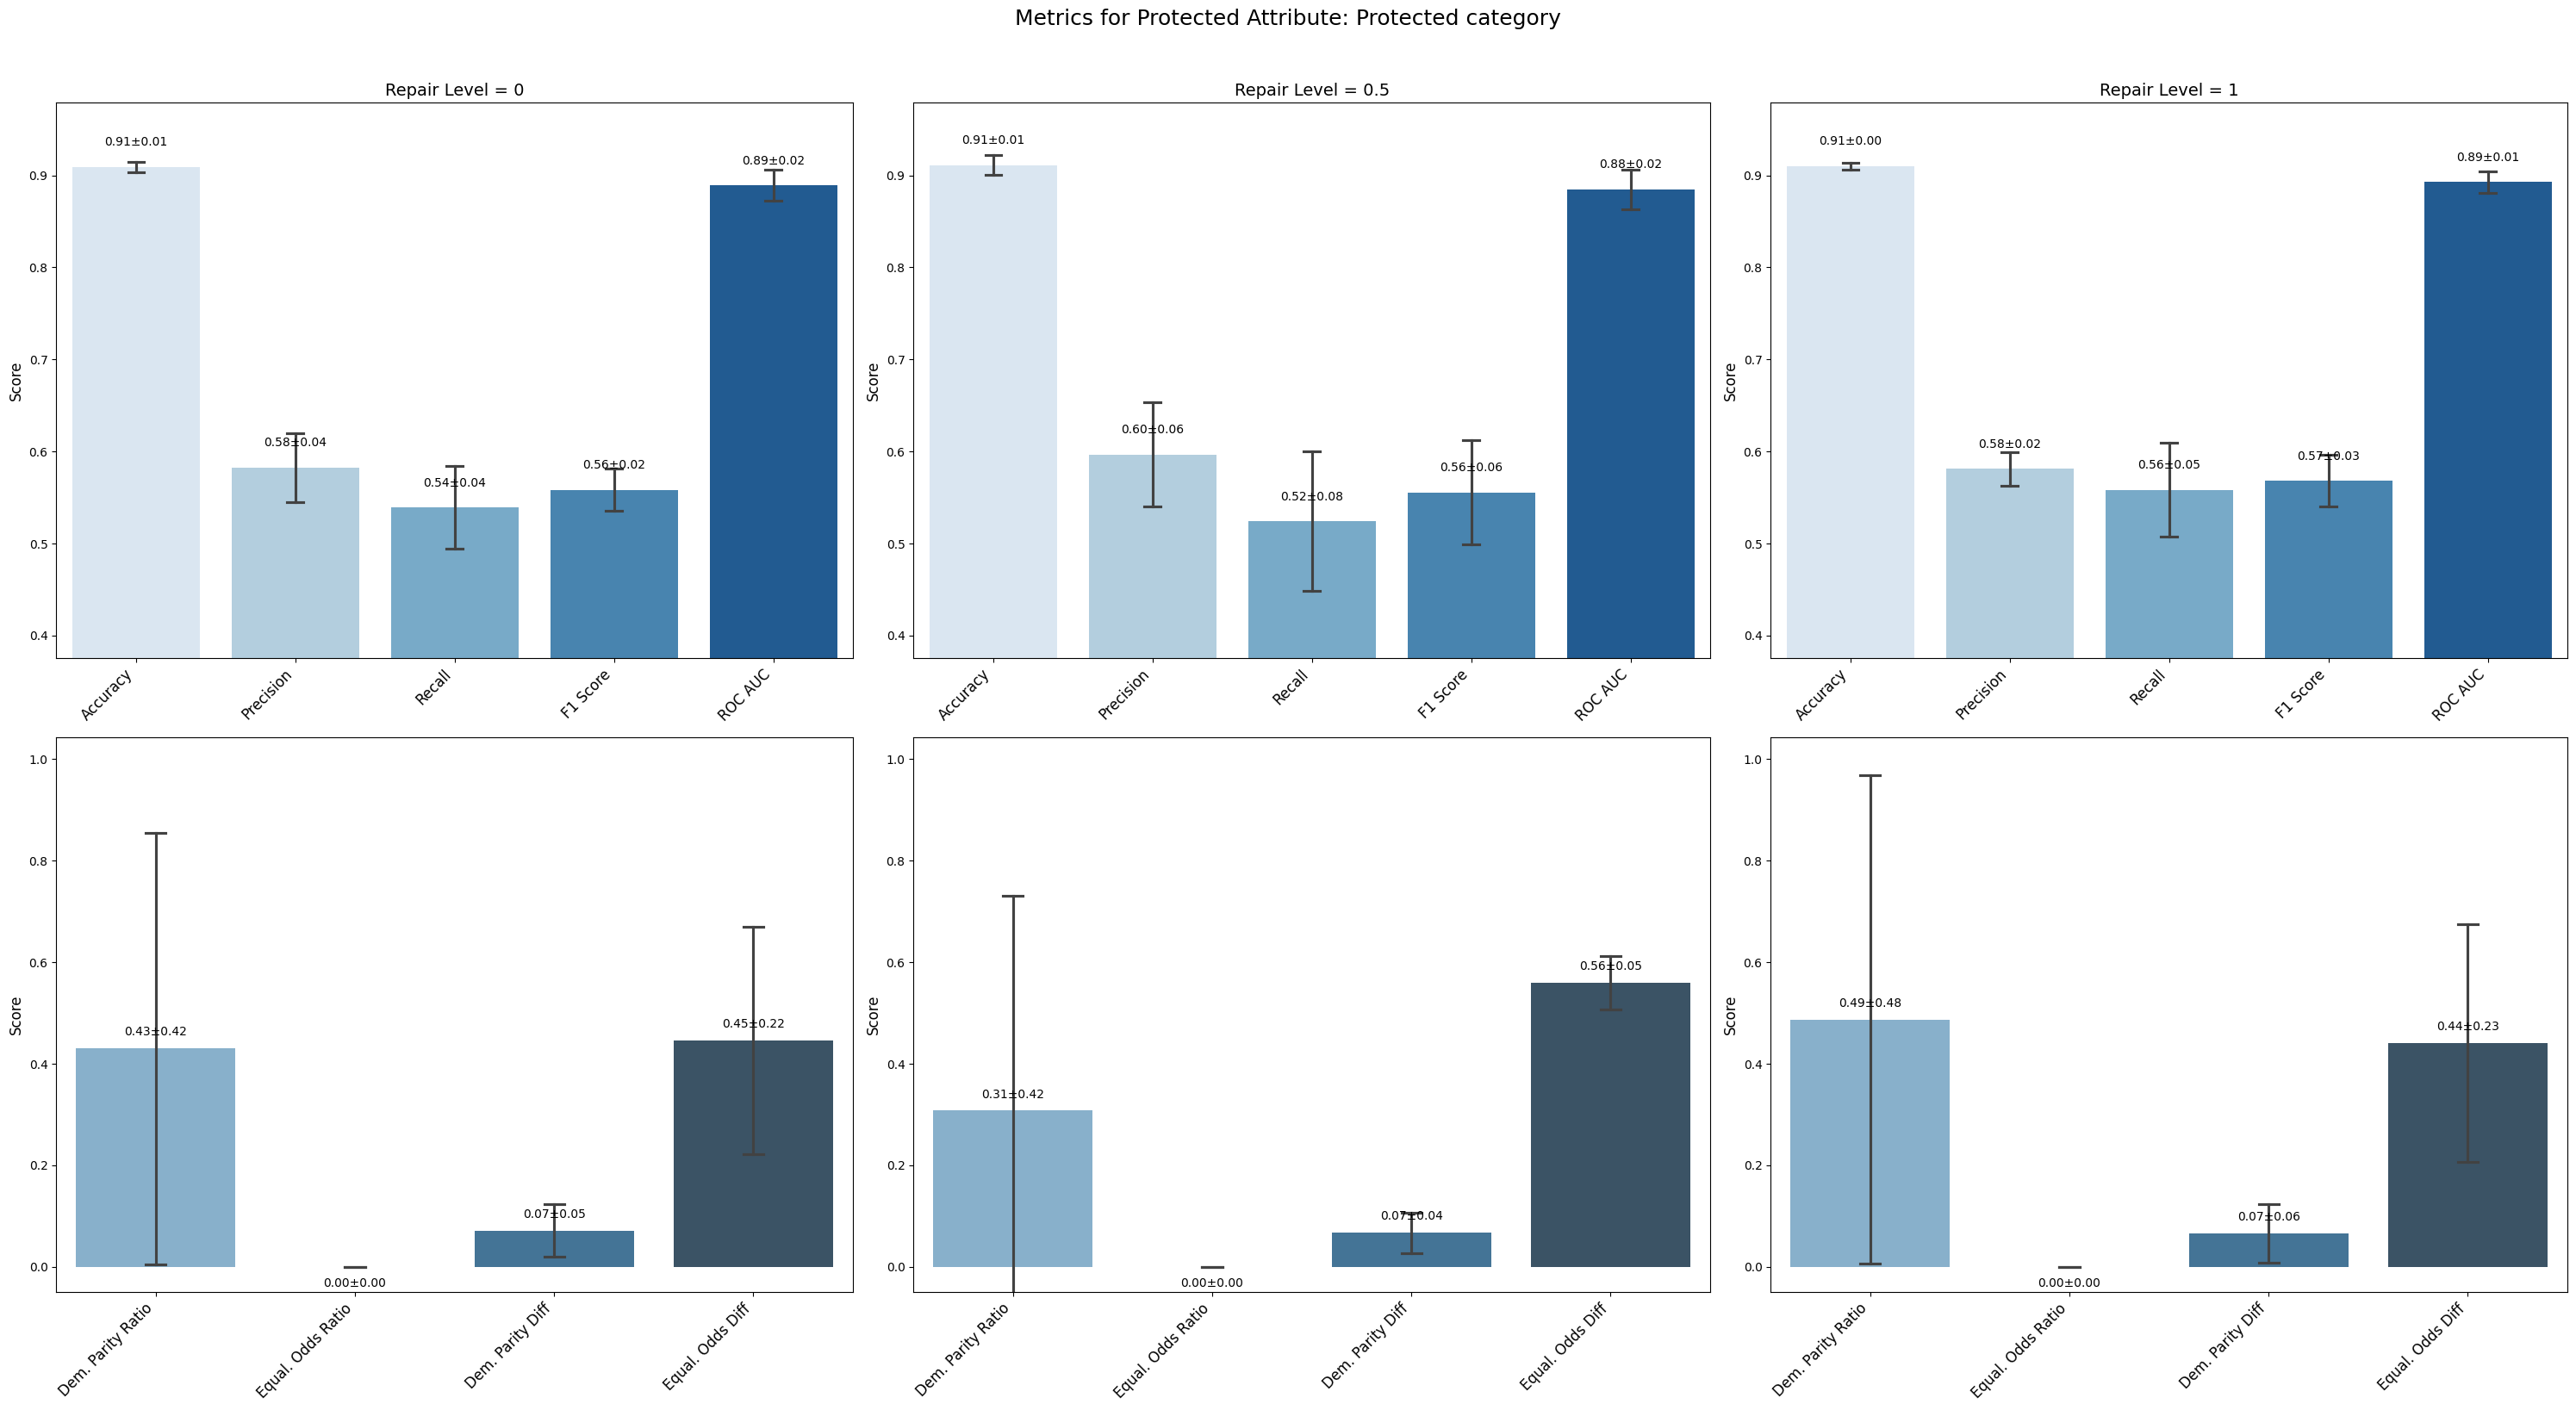

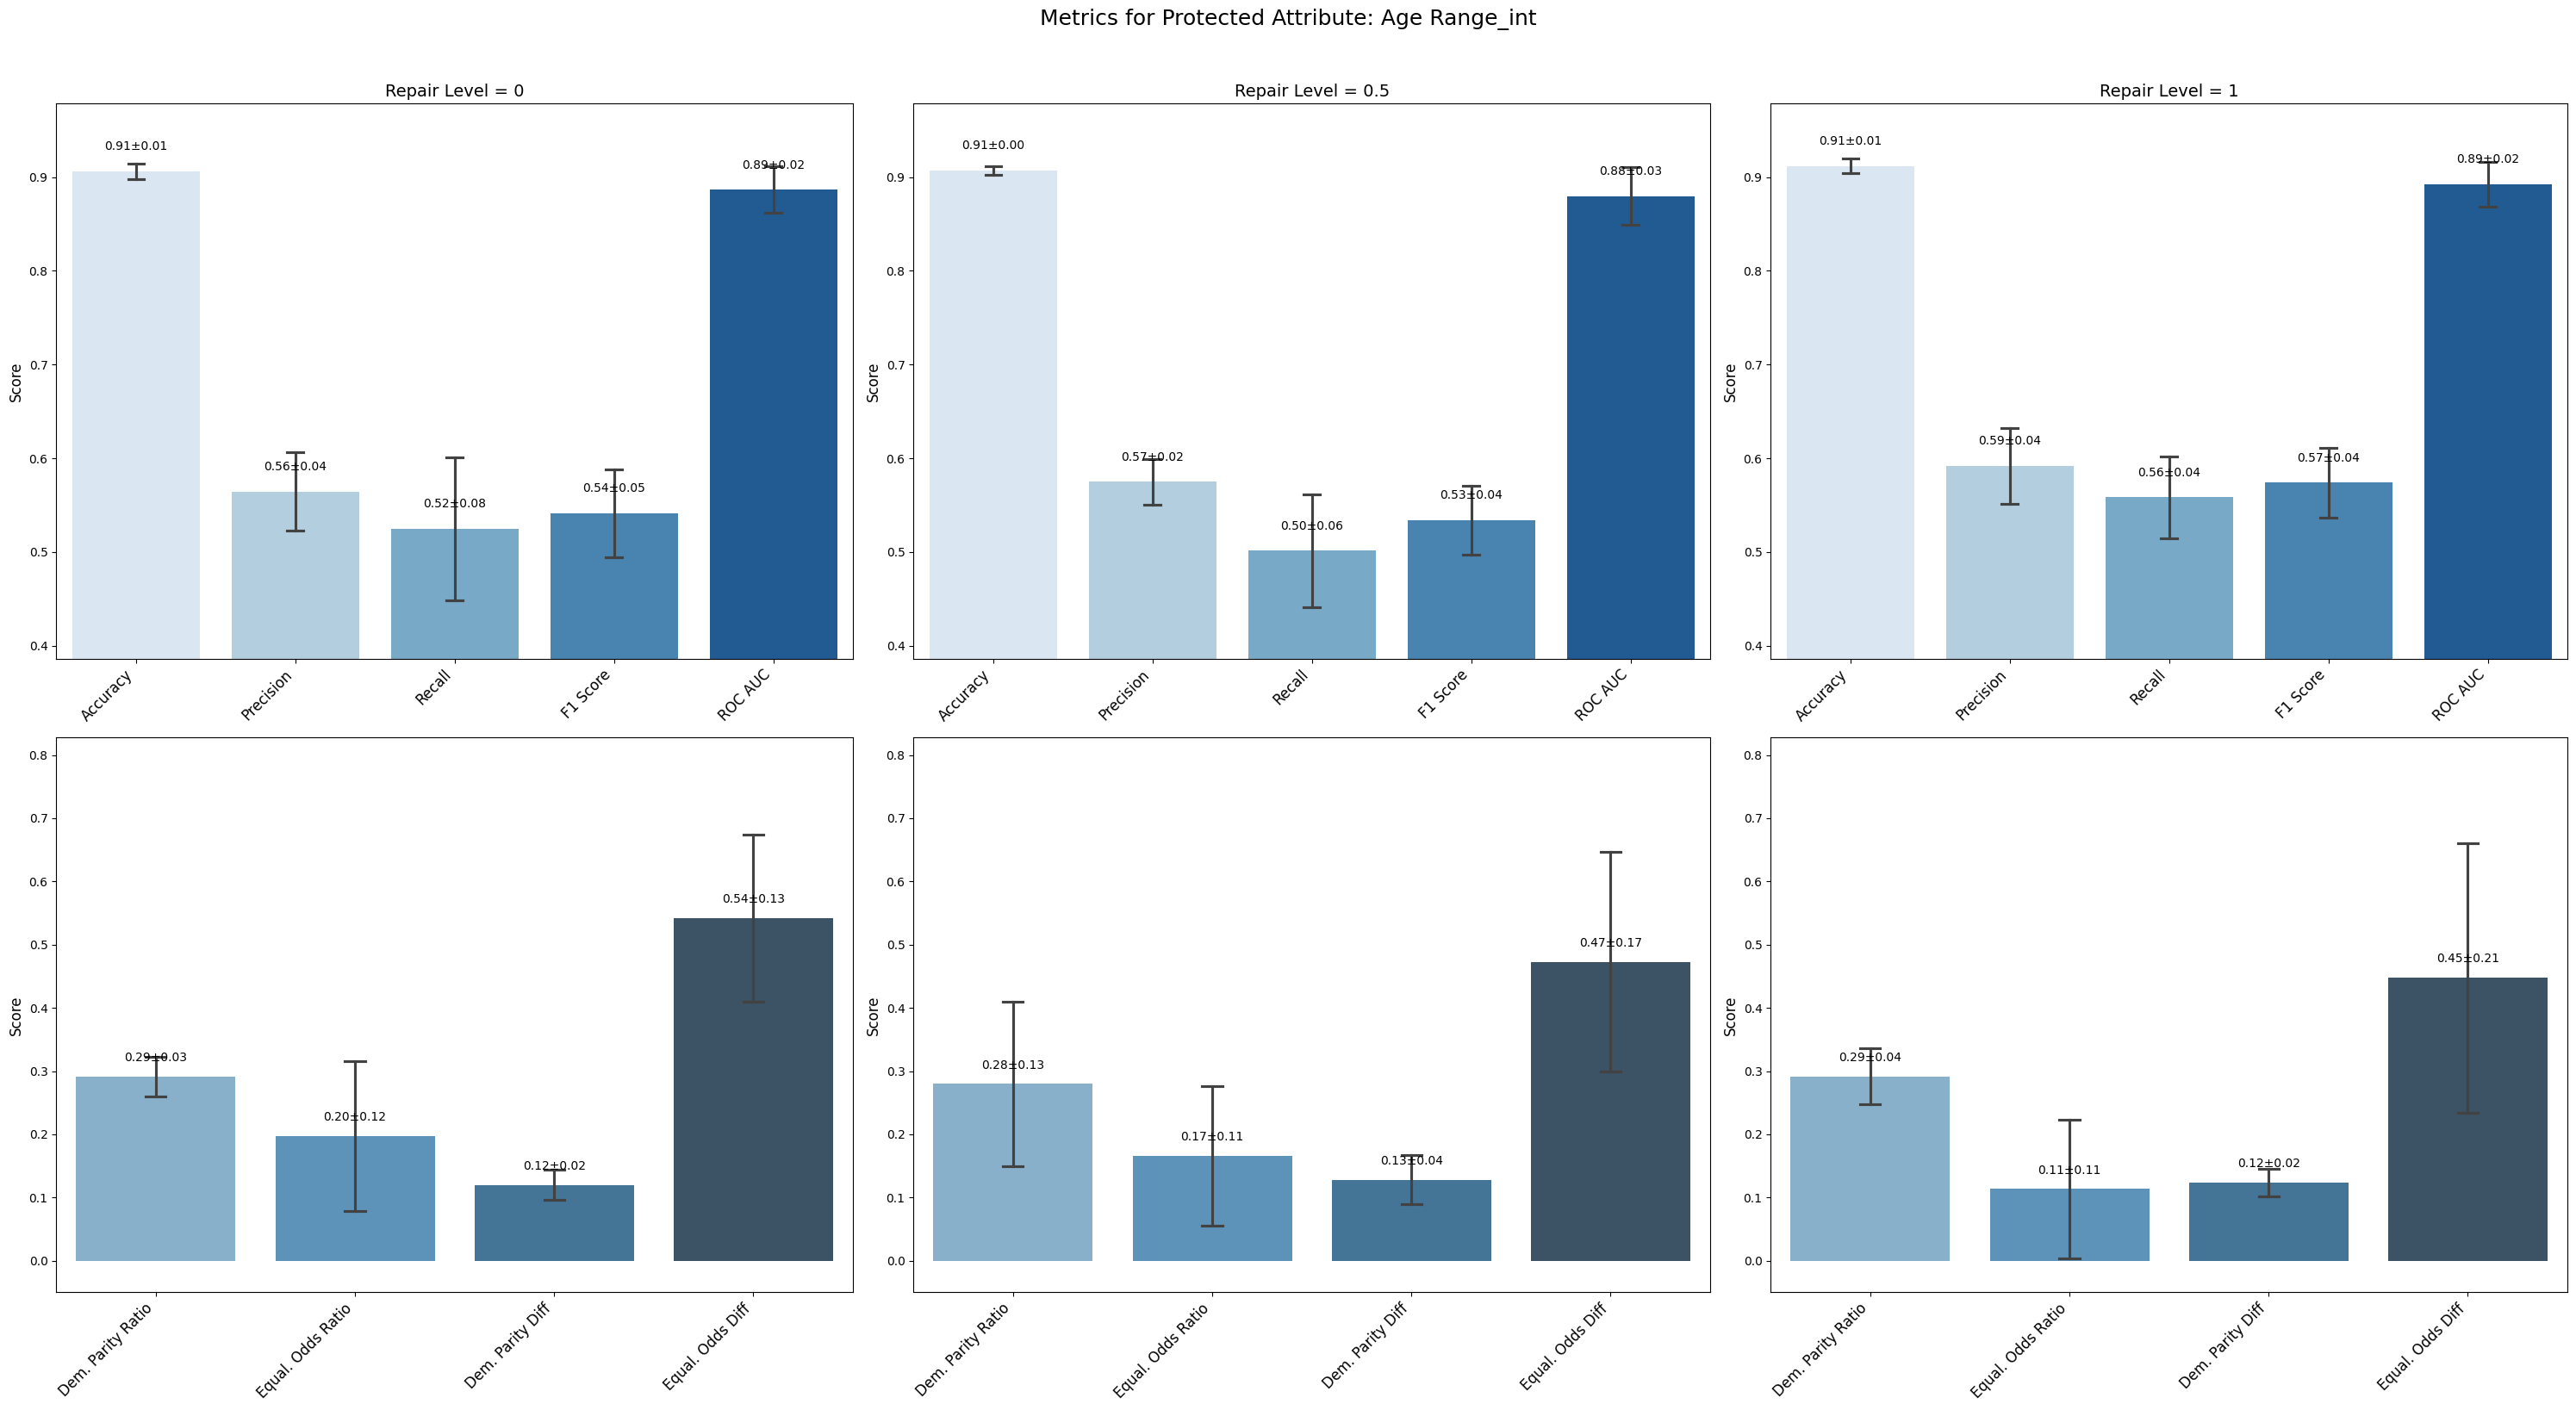

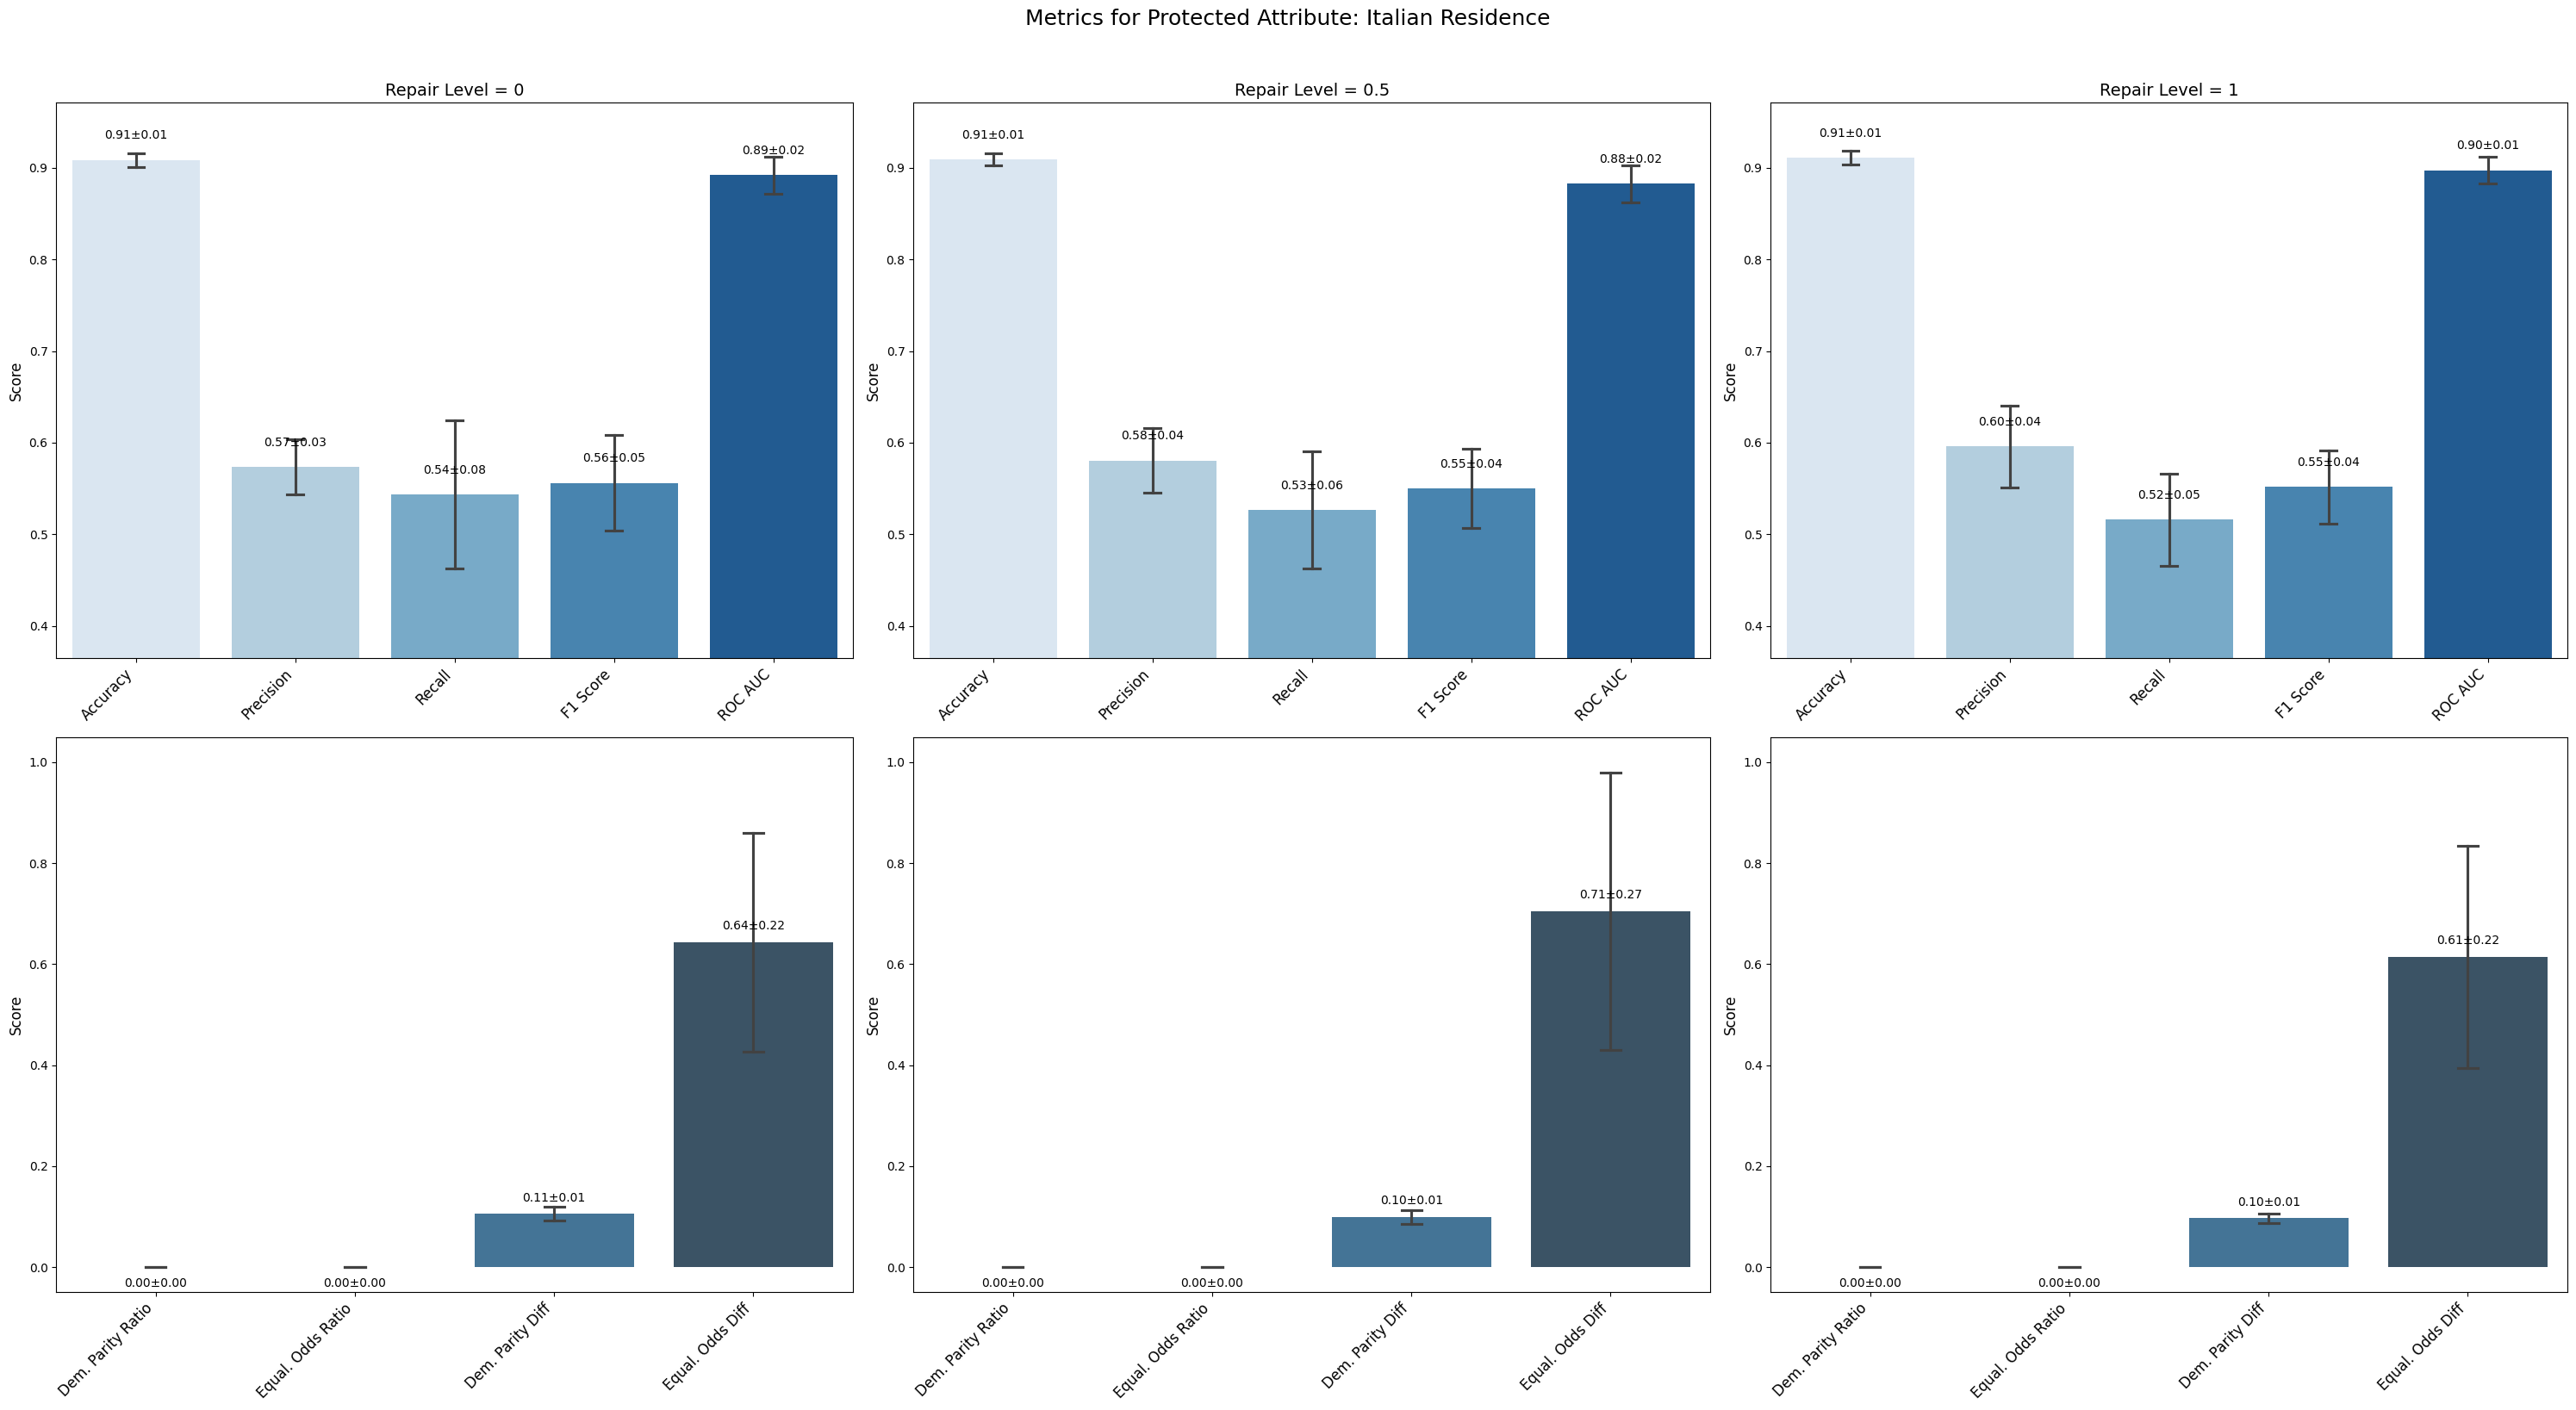

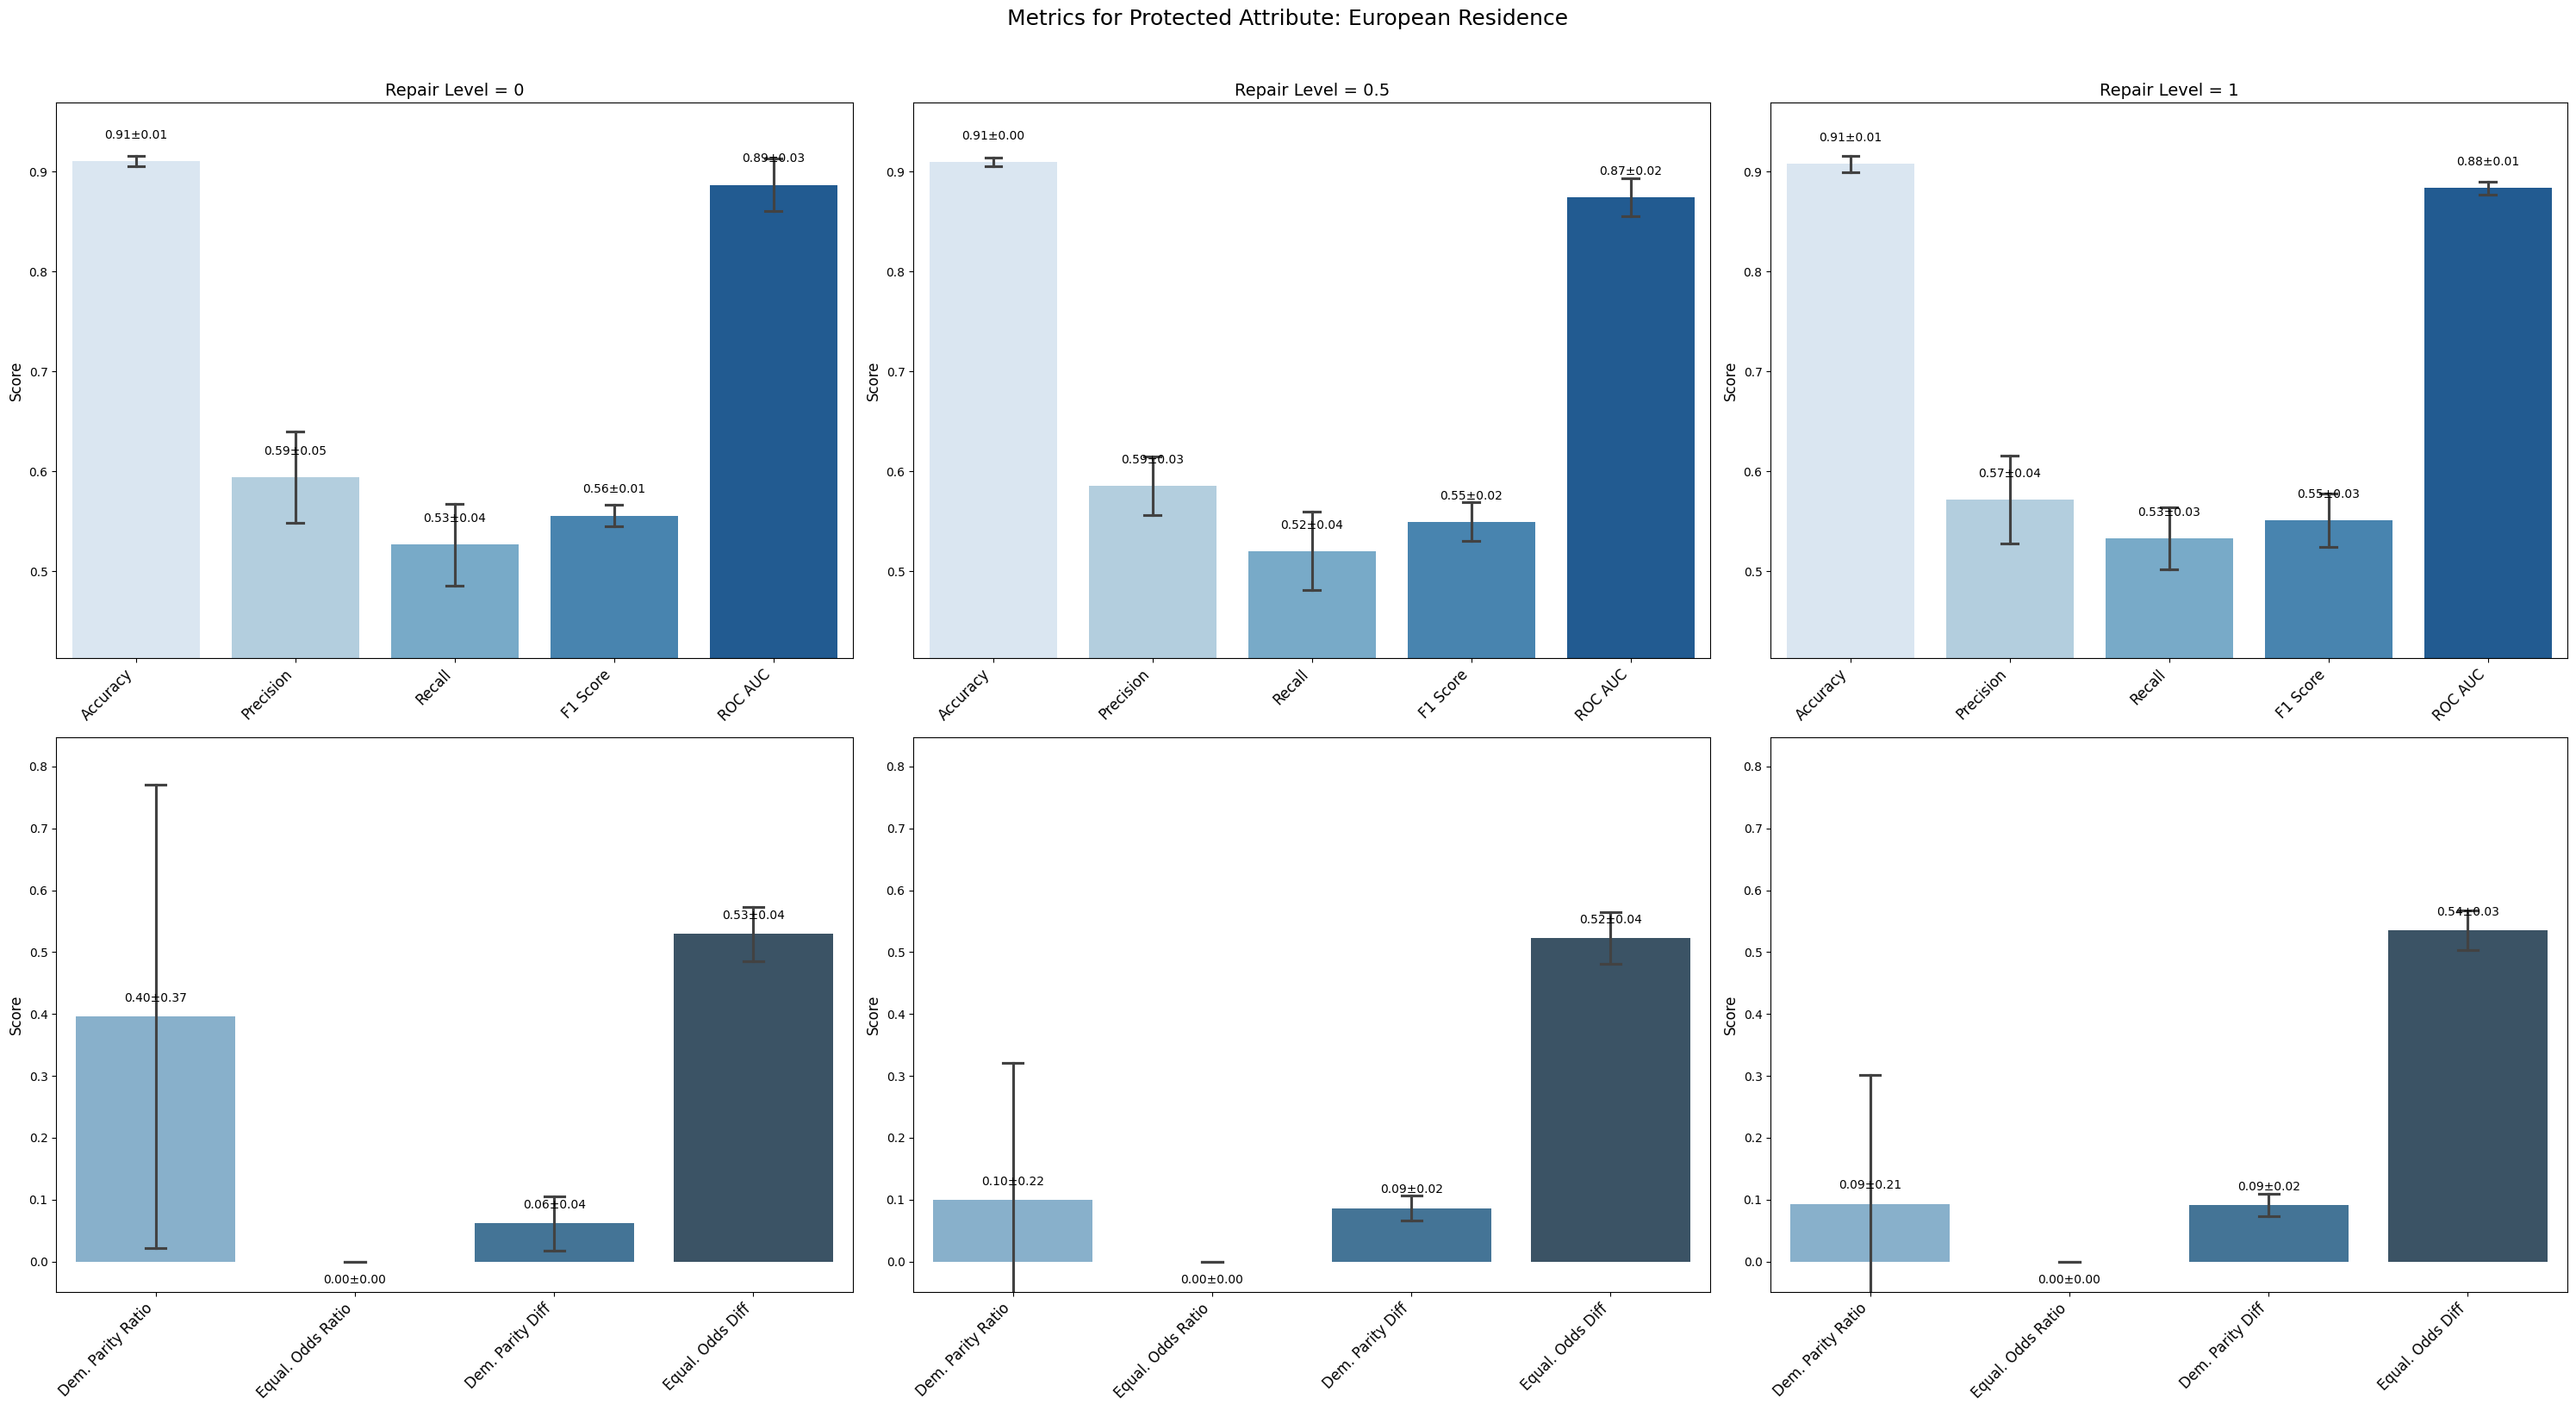

In [34]:
for metric in ['accuracy', 'f1', 'roc_auc', 'demographic_parity_ratio', 'equalized_odds_ratio']:
    plot_metrics(plot_data, metric, repair_levels, protected_attributes)

plot_metrics_grouped(results, 
                     protected_attributes=protected_attributes, 
                     repair_levels=repair_levels)